# Healthy vs. IPF G2G Analysis (AT2 --> AT1 healthy trajectory vs. AT2 --> Aberrant Basaloid trajectory)

In [94]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import pickle
import palantir

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import warnings

# Inline plotting
%matplotlib inline

sb.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

import platform
print(platform.python_version())

3.8.16


In [2]:
adata = anndata.read_h5ad('Kaminski_2020_HLCAlabeltransfer.h5ad')
np.unique(adata.obs.Disease_Identity, return_counts=True)
np.unique(adata.obs.Manuscript_Identity) 
# re annotating HCA obs for  Aberrant_Basaloid as in manuscript identity 
ANNOTATION = []
for i in range(adata.shape[0]):
    if(adata.obs.Manuscript_Identity[i]=='Aberrant_Basaloid'):
        ANNOTATION.append('Aberrant_Basaloid')
    else:
        #ANNOTATION.append(adata.obs.Celltype_HLCA[i])
        ANNOTATION.append(adata.obs.Manuscript_Identity[i])
adata.obs['ANNOTATION'] = ANNOTATION
np.unique(adata.obs.ANNOTATION)
#celltypes_of_interest = ['AT1','AT2','Aberrant_Basaloid', 'Transitional Club-AT2' ]
#adata = adata[[x in celltypes_of_interest for x in adata.obs.ANNOTATION] ] 
np.unique(adata.obs.ANNOTATION, return_counts=True)
np.unique(adata.obs.Manuscript_Identity) 
np.unique(adata.obs.Celltype_HLCA)[52] 
np.unique(adata[adata.obs.Celltype_HLCA =='AT1'].obs.Disease_Identity, return_counts=True)
np.unique(adata[adata.obs.Celltype_HLCA =='AT2'].obs.Disease_Identity, return_counts=True)
np.unique(adata[adata.obs.Manuscript_Identity =='Aberrant_Basaloid'].obs.Disease_Identity, return_counts=True)
np.unique(adata.obs.ANNOTATION)
adata_original = adata.copy()

In [3]:
adata_original.X.data

array([2., 2., 1., ..., 1., 1., 1.], dtype=float32)

# Removing the low quality AT2 cluster 
<-- was a one time run only 

In [ ]:
adata = adata_original.copy()
# removing low quality AT2 cells 
CASE2 = False; celltypes_of_interest = ['ATI','ATII' ] # CASE1 
adata = adata[[x in celltypes_of_interest for x in adata.obs.ANNOTATION] ] 
adata_healthy = adata[adata.obs.Disease_Identity=='Control']
adata_disease = adata[adata.obs.Disease_Identity=='IPF']

# Reset random seed
np.random.seed(5)
temp = adata_disease.copy()
temp = run_palantir_pseudotime(temp)
sc.tl.leiden(temp, key_added='SCVI_leiden')
# IPF data has a strange cluster which accounts for low quality cells (ribo % high) -- so we need to remove it
#sc.pl.embedding(temp[temp.obs.Manuscript_Identity=='ATII'], basis='umap', color=['SCVI_leiden'])
group= [] 
for i in range(temp.shape[0]):
    if(temp.obs.SCVI_leiden[i]=='5'):
        group.append('strange_cluster')
    else:
        group.append('ordinary')
temp.obs['ID'] = group
sc.pl.embedding(temp[temp.obs.Manuscript_Identity=='ATII'], basis='umap', color=['Manuscript_Identity','ID'])
strange_cluster_at2_cells = temp[temp.obs.ID== 'strange_cluster'].obs_names

# mitochondrial genes
temp.var['mt'] = temp.var_names.str.startswith('MT-') 
# ribosomal genes
temp.var['ribo'] = temp.var_names.str.startswith(("RPS","RPL"))
sc.pp.calculate_qc_metrics(temp, qc_vars=['mt','ribo'], percent_top=None, log1p=True, inplace=True)
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html 
mito_genes = temp.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
temp.obs['percent_mt2'] = np.sum(
    temp[:, mito_genes].X, axis=1).A1 / np.sum(temp.X, axis=1).A1

ribo_genes = temp.var_names.str.startswith(("RPS","RPL"))
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
temp.obs['percent_ribo'] = np.sum(
    temp[:, ribo_genes].X, axis=1).A1 / np.sum(temp.X, axis=1).A1
temp.obs['percent_ribo']
sc.pl.embedding(temp, basis='umap', color=['Manuscript_Identity', 'percent_ribo','percent_mt2'])

# Pseudotime estimation using Diffusion Pseudotime 

In [4]:
# found from the above analysis 
strange_cluster_at2_cells = ['021I_CTATTACAGAAGCACC', '021I_CTATTACAGAAGCACT',
       '225I-b_AAAGATGTCCCAGGTG', '225I-b_AAAGTAGCATATACGC',
       '225I-b_AAATGCCCAATAACGA', '225I-b_AACTCAGCACGGTGTC',
       '225I-b_AACTCAGGTCAAACTC', '225I-b_ACACCCTCATGAGCGA',
       '225I-b_ACACTGATCGAGCCCA', '225I-b_ACAGCTAGTTGCGCAC',
       '225I-b_ACCGTAAGTAGCAAAT', '225I-b_ACGGCCATCAGCGACC',
       '225I-b_AGAGTGGGTCCAGTGC', '225I-b_AGCGGTCAGCTAACAA',
       '225I-b_AGCTCCTTCCACGCAG', '225I-b_AGTGGGACACAGTCGC',
       '225I-b_ATGCGATTCTCCAACC', '225I-b_ATGTGTGCATTTGCCC',
       '225I-b_ATTCTACAGGCGCTCT', '225I-b_CACACAAAGGCCCTTG',
       '225I-b_CACACCTCATACTACG', '225I-b_CACCTTGTCATGCAAC',
       '225I-b_CAGCAGCTCTGCCAGG', '225I-b_CAGTCCTCAGCGATCC',
       '225I-b_CATCCACCACGGTAGA', '225I-b_CCCATACCAGCATACT',
       '225I-b_CGCTTCAGTAAAGTCA', '225I-b_CGTTAGATCGGCTTGG',
       '225I-b_CGTTGGGGTCTCCATC', '225I-b_CTACGTCAGGCAGGTT',
       '225I-b_CTCGAAATCGGTTAAC', '225I-b_GACGGCTGTCCAGTTA',
       '225I-b_GATCAGTTCACATGCA', '225I-b_GCACATATCGCGTAGC',
       '225I-b_GCACTCTAGACGCACA', '225I-b_GCAGTTAGTAAGGGAA',
       '225I-b_GCATGATTCACATACG', '225I-b_GGAAAGCGTCTAACGT',
       '225I-b_GTATTCTTCGGCTTGG', '225I-b_GTCACGGAGTGGGTTG',
       '225I-b_GTCACGGCACTCAGGC', '225I-b_GTCATTTGTATTACCG',
       '225I-b_GTCATTTTCAGCATGT', '225I-b_GTCTTCGCACTCGACG',
       '225I-b_GTTCTCGTCGGCCGAT', '225I-b_TAAGAGACATGCAACT',
       '225I-b_TAAGTGCGTGCAGTAG', '225I-b_TACTCATAGCCGCCTA',
       '225I-b_TCAACGAAGGACAGAA', '225I-b_TCATTACGTAGTGAAT',
       '225I-b_TTAACTCAGTATTGGA', '225I-b_TTAGGCATCTTACCGC',
       '225I-b_TTTACTGCAACACGCC', '225I-b_TTTGGTTTCAGGTAAA']

In [5]:
len(strange_cluster_at2_cells)

54

In [6]:
# from literature
AT2_progenitor_markers = ['AXIN2','FGFR2', 'ID2', 'FZD6','LRP5','LRP6'] 
AT1_markers = ['AGER','RTKN2','CLIC5']
Aberrant_markers = ['VIM','MMP7','FN1']

def get_data():

    adata = adata_original.copy()
    print(adata.shape)
    #CASE2 = False; celltypes_of_interest = ['ATI','ATII' ] # CASE1 
    CASE2 = True; celltypes_of_interest = ['ATII','Aberrant_Basaloid','ATI' ] 
    adata = adata[[x in celltypes_of_interest for x in adata.obs.ANNOTATION] ] 

    adata_healthy = adata[adata.obs.Disease_Identity=='Control']
    adata_disease = adata[adata.obs.Disease_Identity=='IPF']
    print(adata_healthy.shape)
    print(adata_disease.shape)
    print(adata_healthy.X.data)
    print(adata_disease.X.data) 
    if(CASE2): 
        adata_disease = adata_disease[ adata_disease.obs.ANNOTATION != 'ATI' ] 
    print(np.unique(adata_healthy.obs.ANNOTATION, return_counts=True)) 
    print(np.unique(adata_disease.obs.ANNOTATION, return_counts=True)) 
    adata_disease = adata_disease[[c not in strange_cluster_at2_cells for c in adata_disease.obs_names] ] 
    
    return adata_healthy, adata_disease

def estimate_dpt_pseudotime(adata_WT,ANNO_COLNAME,ROOT_CELLTYPE ):
    print('====== DPT RUN ====== ')
    sc.pp.normalize_per_cell(adata_WT, 10000) 
    sc.pp.log1p(adata_WT)
    sc.pp.highly_variable_genes(adata_WT, n_top_genes=4000)
    sc.tl.score_genes(adata_WT, gene_list=AT2_progenitor_markers, score_name='dpt_start_score')
    adata_WT.raw = adata_WT.copy()
    adata_WT = adata_WT[:, adata_WT.var.highly_variable]
    sc.pp.neighbors(adata_WT)
    sc.tl.umap(adata_WT)
    sc.tl.leiden(adata_WT, key_added='leiden_normal', resolution=0.1)
    ref_sub = adata_WT.copy()
    sc.tl.diffmap(ref_sub)
    sc.pp.neighbors(ref_sub,use_rep='X_diffmap')
    sc.tl.leiden(ref_sub, key_added='leiden_diffmap', resolution=0.1)
    
    #rootcell = np.argmax(ref_sub.raw[:,'AXIN2'].X )#+ ref_sub.raw[:,'FGFR2'].X + ref_sub.raw[:,'ID2'].X  )
    #root_comp = ref_sub.raw[:,AT2_progenitor_markers[0]].X
    #for marker in AT2_progenitor_markers:
    #    root_comp += ref_sub.raw[:,marker].X
    #rootcell = np.argmax(root_comp)
    rootcell = np.argmax(ref_sub.obs.dpt_start_score)
    
    print(rootcell)
    ref_sub.uns['iroot'] = rootcell
    ref_sub.obs['rootcell'] = 0
    ref_sub.obs['rootcell'][rootcell] = 1
    sc.pl.umap(ref_sub,color='rootcell',color_map='OrRd')
    sc.tl.dpt(ref_sub)
    return ref_sub


def run_palantir_pseudotime(adata, TERMINAL_STATE, ROOT_STATE):
    print('====== PALANTIR RUN ====== ')
    sc.pp.normalize_per_cell(adata, 10000)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000)
    sc.tl.score_genes(adata, gene_list=AT2_progenitor_markers, score_name='start_score')
    if(TERMINAL_STATE=='ATI'):
        sc.tl.score_genes(adata, gene_list=AT1_markers, score_name='end_score')
    else:
        sc.tl.score_genes(adata, gene_list=Aberrant_markers, score_name='end_score')

    sc.pp.pca(adata)
    # Run diffusion maps
    pca_projections = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
    dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
    ms_data = palantir.utils.determine_multiscale_space(dm_res)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    adata.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(adata, dm_res)
    umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)

    rootcell = np.argmax(adata.obs.start_score)
    terminalcell = np.argmax(adata.obs.end_score)
    
    terminal_states = pd.Series([TERMINAL_STATE], index=[adata.obs_names[terminalcell] ])
    adata.uns['iroot'] = rootcell
    start_cell =  adata.obs_names[rootcell]
    adata.obs['rootcell'] = 0
    adata.obs['rootcell'][start_cell] = 1
    terminal_cell =  adata.obs_names[terminalcell]
    adata.obs['terminalcell'] = 0
    adata.obs['terminalcell'][terminal_cell] = 1
    
    sc.pl.umap(adata,color=['rootcell','terminalcell'],color_map='OrRd')
    
    
    pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)
    pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]
    adata.obs['palantir_pseudotime'] = pr_res.pseudotime
    return adata

In [ ]:
adata_healthy, adata_disease = get_data() 
temp_disease = estimate_dpt_pseudotime(adata_disease.copy(), ANNO_COLNAME='ANNOTATION',ROOT_CELLTYPE='ATII')
temp_disease_p = run_palantir_pseudotime(adata_disease.copy(), ROOT_STATE='ATII', TERMINAL_STATE='Aberrant_Basaloid')
adata_disease.obs['dpt_pseudotime'] = temp_disease.obs['dpt_pseudotime']
adata_disease.obsm['X_umap'] = temp_disease.obsm['X_umap']
adata_disease.obsm['X_diffmap'] = temp_disease.obsm['X_diffmap']
adata_disease.obs['leiden_normal'] = temp_disease.obs['leiden_normal']
adata_disease.obs['leiden_diffmap'] = temp_disease.obs['leiden_diffmap']
adata_disease.obs['palantir_pseudotime'] = temp_disease_p.obs['palantir_pseudotime']
adata_disease.obs['palantir_start_score']  = temp_disease_p.obs['start_score']
adata_disease.obs['dpt_start_score']  = temp_disease.obs['dpt_start_score']
adata_disease.obs['palantir_end_score']  = temp_disease_p.obs['end_score']
sc.pl.embedding(adata_disease, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'palantir_pseudotime','leiden_normal','leiden_diffmap', 
                                                   'dpt_start_score' , 'palantir_start_score','palantir_end_score'], legend_loc='on data')

In [ ]:
#adata_healthy, adata_disease = get_data() 
temp_healthy = estimate_dpt_pseudotime(adata_healthy.copy(), ANNO_COLNAME='ANNOTATION',ROOT_CELLTYPE='ATII')
temp_healthy_p = run_palantir_pseudotime(adata_healthy.copy(), ROOT_STATE='ATII', TERMINAL_STATE='ATI')
adata_healthy.obs['dpt_pseudotime'] = temp_healthy.obs['dpt_pseudotime']
adata_healthy.obsm['X_umap'] = temp_healthy.obsm['X_umap']
adata_healthy.obsm['X_diffmap'] = temp_healthy.obsm['X_diffmap']
adata_healthy.obs['leiden_normal'] = temp_healthy.obs['leiden_normal']
adata_healthy.obs['leiden_diffmap'] = temp_healthy.obs['leiden_diffmap']
adata_healthy.obs['palantir_pseudotime'] = temp_healthy_p.obs['palantir_pseudotime']
adata_healthy.obs['palantir_start_score']  = temp_healthy_p.obs['start_score']
adata_healthy.obs['dpt_start_score']  = temp_healthy.obs['dpt_start_score']
adata_healthy.obs['palantir_end_score']  = temp_healthy_p.obs['end_score']
sc.pl.embedding(adata_healthy, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'palantir_pseudotime','leiden_normal','leiden_diffmap', 
                                                   'dpt_start_score' , 'palantir_start_score','palantir_end_score'], legend_loc='on data')

In [11]:
hvgs = [] 
for g in adata_healthy.var_names:
    hvgs.append(g in temp_healthy.var_names)
adata_healthy.var['HVG'] = hvgs 

In [12]:
hvgs = [] 
for g in adata_disease.var_names:
    hvgs.append(g in temp_disease.var_names)
adata_disease.var['HVG'] = hvgs 

In [13]:
common_genes = np.intersect1d(adata_disease.var_names, adata_healthy.var_names )
print(len(common_genes))
print(adata_healthy.shape)
print(adata_disease.shape)
adata_healthy.write_h5ad('adata_healthy_AT2_to_AT1.h5ad')
adata_disease.write_h5ad('adata_IPF_AT2_to_AberrantB.h5ad')

45947
(3157, 45947)
(890, 45947)


# G2G Alignment

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import VisualUtils
import PathwayAnalyserV2
import warnings
warnings.filterwarnings("ignore")
# Plotting 
import matplotlib
import warnings
import platform
import pickle
# Inline plotting
%matplotlib inline
sb.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")
print(platform.python_version())

dir_path = '../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'

adata_healthy = anndata.read_h5ad(dir_path + 'adata_healthy_AT2_to_AT1.h5ad')
adata_disease = anndata.read_h5ad(dir_path + 'adata_IPF_AT2_to_AberrantB.h5ad')

#with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/aligner_healthy_IPF.pkl', 'rb') as f:
#    aligner = pickle.load(f)

(CVXPY) Oct 10 07:17:17 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 10 07:17:17 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
3.9.16


In [4]:
adata_healthy.obs['time'] = adata_healthy.obs['dpt_pseudotime']
adata_disease.obs['time'] = adata_disease.obs['dpt_pseudotime']

In [6]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_healthy.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

13

In [7]:
print(adata_healthy.shape)
print(adata_disease.shape)

(3157, 45947)
(890, 45947)


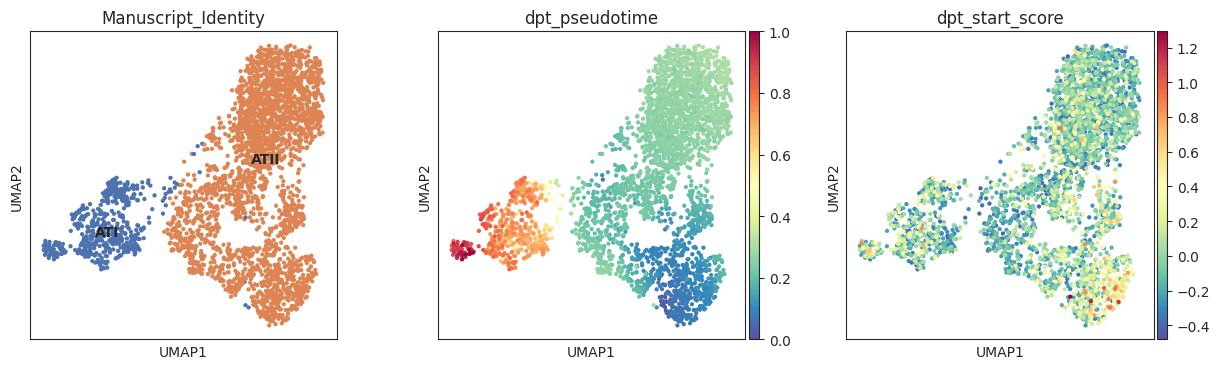

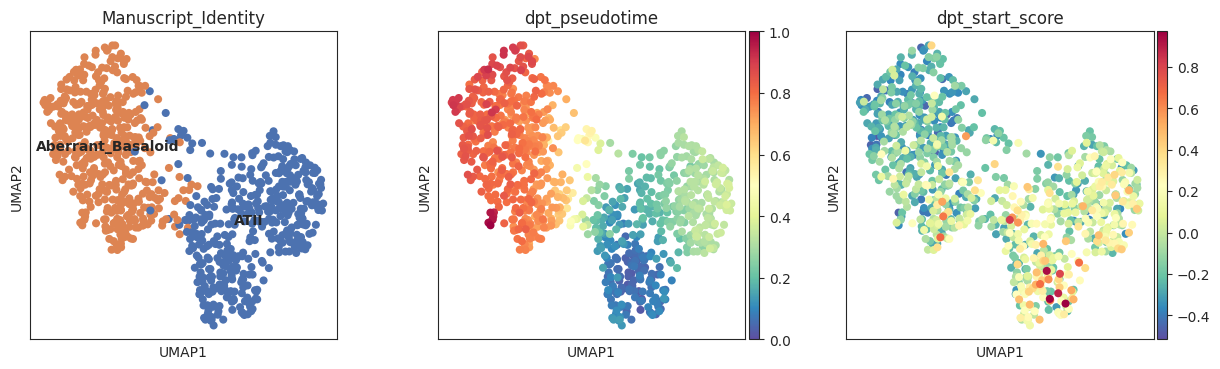

In [4]:
sc.pl.embedding(adata_healthy, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')
sc.pl.embedding(adata_disease, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')

In [3]:
common_hvg_genes = np.intersect1d(adata_healthy.var_names[adata_healthy.var.HVG] , adata_disease.var_names[adata_disease.var.HVG] )
len(common_hvg_genes)

994

0.0 1.0
0.0 1.0


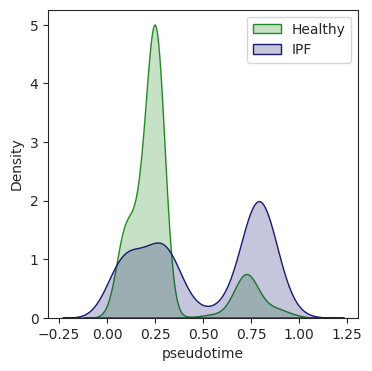

In [4]:
print( np.min(adata_healthy.obs.dpt_pseudotime) , np.max(adata_healthy.obs.dpt_pseudotime) ) 
print( np.min(adata_disease.obs.dpt_pseudotime) , np.max(adata_disease.obs.dpt_pseudotime) ) 
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_healthy.obs['dpt_pseudotime'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_disease.obs['dpt_pseudotime'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()
adata_healthy.obs['time'] = adata_healthy.obs['dpt_pseudotime']
adata_disease.obs['time'] = adata_disease.obs['dpt_pseudotime']

# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


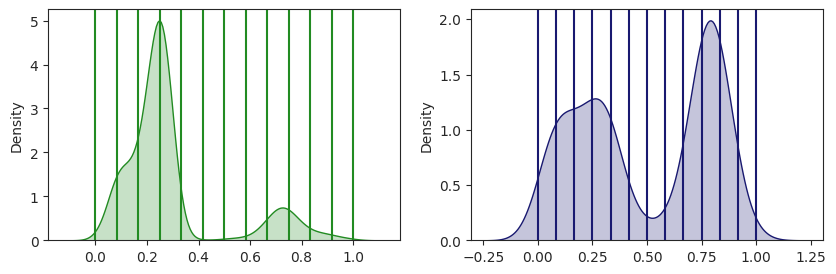

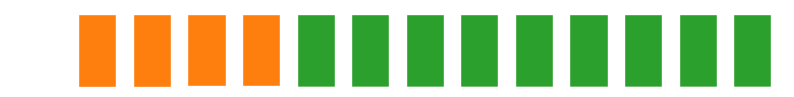

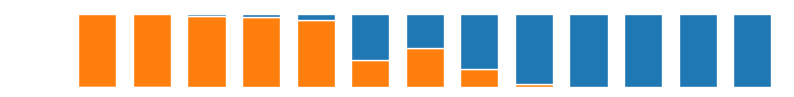

In [5]:
joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_healthy, adata_disease, n_points=13, 
                                     ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

In [8]:
adata_ref = adata_healthy
adata_query = adata_disease
print(adata_ref.X.data) 
print(adata_query.X.data)
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)
print(adata_ref.X.data)
print(adata_query.X.data)

[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]
[1.7595813 1.7595813 3.0076618 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]


In [10]:
# RUN G2G ALIGNMENT
RUN_G2G = False
if(RUN_G2G):
    aligner = Main.RefQueryAligner(adata_ref, adata_query, common_hvg_genes, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs()

WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

In [9]:
#pickle.dump(aligner, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_healthy_IPF.pkl', 'wb')) 
with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_healthy_IPF.pkl', 'rb') as f:
    aligner = pickle.load(f)

In [20]:
#aligner.show_ordered_alignments() 

Average Alignment:  MMMMMMMMMMIMDID


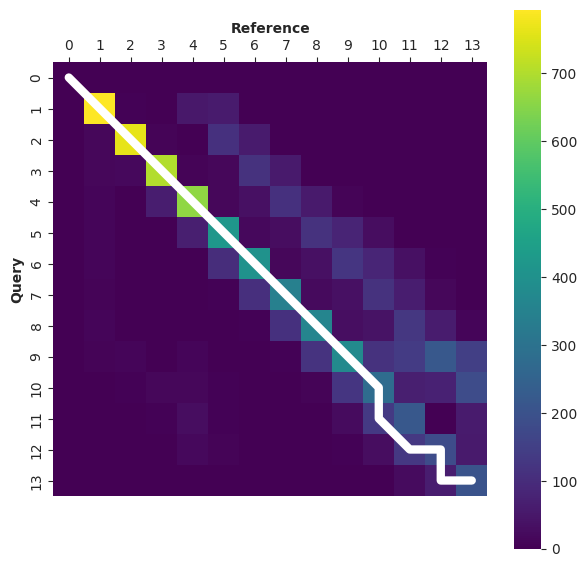

In [10]:
aligner.get_aggregate_alignment()
#plt.savefig('MS_FIGS/HealthyIPF/average_alignment_all_hvgs.png')

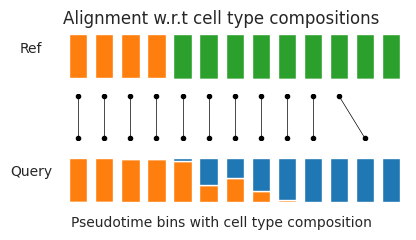

In [11]:
vs.visualize_gene_alignment("MMMMMMMMMMIMDID", cmap=joint_cmap)
plt.savefig('MS_FIGS/HealthyIPF/average_alignment_illustration.pdf', bbox_inches='tight')

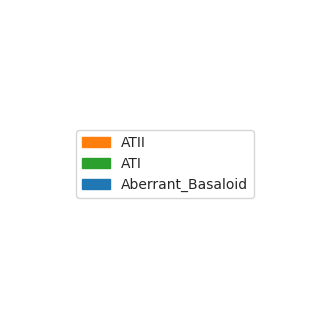

In [12]:
VisualUtils.plot_any_legend(joint_cmap)
plt.savefig('MS_FIGS/HealthyIPF/legend.pdf', bbox_inches='tight')

mean matched percentage: 
60.809999999999995 %


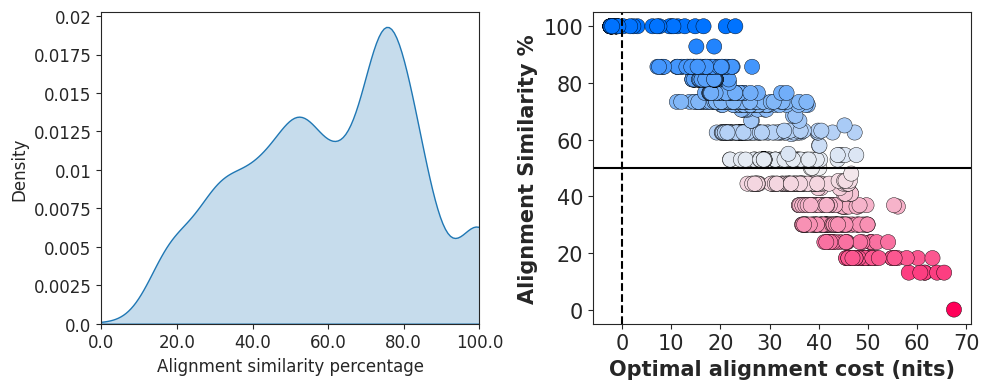

In [11]:
df = aligner.get_stat_df() #VisualUtils.plot_alignmentSim_vs_optCost(df, opt_cost_cut=50)
#plt.savefig('MS_FIGS/HealthyIPF/al_distribution.png', bbox_inches='tight')

In [12]:
# selecting reasonable thresholds by manual inspection to identify top/highly distant genes
# this call might sometime gives 'error sending list' from GSEAPy package function call -
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.4)]['Gene']
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df

Gene_set                                               Term  \
0   MSigDB_Hallmark_2020                  Epithelial Mesenchymal Transition   
41       KEGG_2021_Human  AGE-RAGE signaling pathway in diabetic complic...   
42       KEGG_2021_Human                           ECM-receptor interaction   
43       KEGG_2021_Human                                     Focal adhesion   
44       KEGG_2021_Human                                         Amoebiasis   
1   MSigDB_Hallmark_2020                              Inflammatory Response   
45       KEGG_2021_Human                             Small cell lung cancer   
2   MSigDB_Hallmark_2020                      TNF-alpha Signaling via NF-kB   
3   MSigDB_Hallmark_2020                                  Androgen Response   
4   MSigDB_Hallmark_2020                               IL-2/STAT5 Signaling   
5   MSigDB_Hallmark_2020                                            Hypoxia   
6   MSigDB_Hallmark_2020                                    Apical Junction   
7   MSigDB_Hallmark_2020                                        p53 Pathway   
8   MSigDB_Hallmark_2020                                  KRAS Signaling Up   
46       KEGG_2021_Human                     Human papillomavirus infection   
47       KEGG_2021_Human                         PI3K-Akt signaling pathway   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   16/200  5.389872e-10      2.209848e-08            0                     0   
41  10/100  1.246035e-07      2.392387e-05            0                     0   
42    8/88  4.812762e-06      4.620251e-04            0                     0   
43  11/201  1.183309e-05      6.930857e-04            0                     0   
44   8/102  1.443928e-05      6.930857e-04            0                     0   
1   10/200  6.369418e-05      1.305731e-03            0                     0   
45    7/92  6.080511e-05      2.334916e-03            0                     0   
2    9/200  3.246772e-04      4.437254e-03            0                     0   
3    6/100  7.408899e-04      7.594122e-03            0                     0   
4    7/199  5.845951e-03      2.735249e-02            0                     0   
5    7/200  6.004204e-03      2.735249e-02            0                     0   
6    7/200  6.004204e-03      2.735249e-02            0                     0   
7    7/200  6.004204e-03      2.735249e-02            0                     0   
8    7/200  6.004204e-03      2.735249e-02            0                     0   
46  11/331  9.507368e-04      3.042358e-02            0                     0   
47  11/354  1.625932e-03      4.459699e-02            0                     0   

    Odds Ratio  Combined Score  \
0     8.564999      182.788461   
41   10.674797      169.709296   
42    9.519324      116.556878   
43    5.561017       63.087567   
44    8.095796       90.232164   
1     5.030809       48.604743   
45    7.799774       75.718930   
2     4.481930       36.001902   
3     6.013743       43.345008   
4     3.434270       17.659036   
5     3.416301       17.475390   
6     3.416301       17.475390   
7     3.416301       17.475390   
8     3.416301       17.475390   
46    3.279948       22.822774   
47    3.056394       19.627166   

                                                Genes  \
0   NNMT;CXCL8;NTM;ITGA2;LAMA3;FN1;TNC;PLOD2;LAMC2...   
41  CXCL8;COL4A2;COL4A1;AKT3;FN1;PLCE1;CCL2;NFATC1...   
42      COL4A2;COL4A1;ITGA2;LAMA3;TNC;FN1;ITGB8;LAMC2   
43  COL4A2;COL4A1;CAV1;ITGA2;AKT3;LAMA3;FN1;TNC;IT...   
44    CXCL8;COL4A2;IL1R1;COL4A1;LAMA3;FN1;LAMC2;RAB7A   
1   ABCA1;HRH1;CXCL8;GCH1;IL1R1;CCL20;SLC11A2;ITGB...   
45           COL4A2;COL4A1;ITGA2;AKT3;LAMA3;FN1;LAMC2   
2   ABCA1;TNFAIP8;GCH1;CCL20;DDX58;TNC;CCL2;SLC2A3...   
3             TNFAIP8;HMGCS1;BMPR1B;NDRG1;PLPP1;FKBP5   
4           SOCS2;MYO1E;P4HA1;SLC2A3;NDRG1;AGER;PLPP1   
5         P4HA1;CAV1;S100A4;SLC2A3;ANGPTL4;NDRG1;MT1E   
6             BMP1;ITGA2;AKT3;L

In [13]:
len(topDEgenes)

215

In [ ]:
pathway_df.to_csv('results/HealthyIPF_overrep_results_top_k_DE_threshold_0.4sim_215genes.csv')

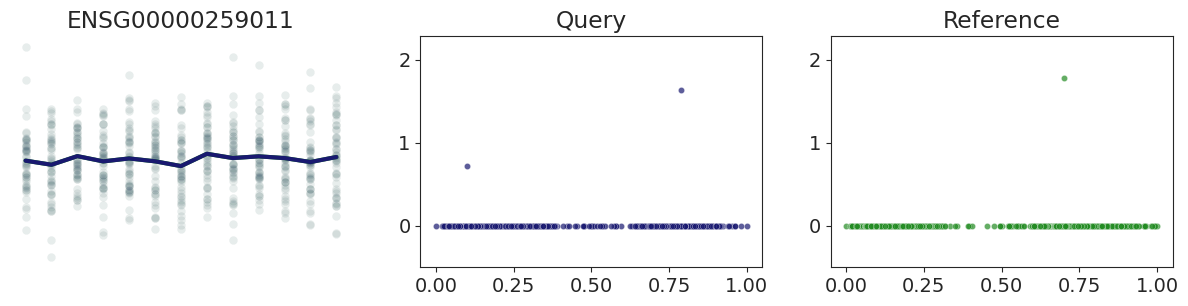

In [94]:
VisualUtils.plotTimeSeries('ENSG00000259011', aligner)

In [95]:
#aligner.show_ordered_alignments() 

In [81]:
temp = []; als = []
for g in IGS.SETS['EMT']:
    print(g,  VisualUtils.color_al_str(aligner.results_map[g].alignment_str), aligner.results_map[g].get_opt_alignment_cost()) 
    als.append(aligner.results_map[g].alignment_str)
    temp.append(aligner.results_map[g].get_opt_alignment_cost())

ABI3BP MMMIIIIIIMMMDDIDDDDD 40.28581887073012
ADAM12 MMMMMMMMMWWWWIIII 18.576351071556193
BMP1 MMMMIIIIIIDIDIDIDDDDDD 46.02325705572444
CALD1 MMMMIIIIIIDIDIDIDDDDDD 45.907721078863084
COL12A1 MMMMMMVVVVIDIDIDDDDD 40.1129674745339
COL4A1 MMMMIIIIDDDIDMMMIDD 41.58471402771529
COL4A2 MMMMMIDIIDIDMMIIDDD 39.817451783196795
COL6A2 MMMIMMMMMWWWWWIIII 27.16979581213856
CXCL1 MIMMMMMMMWWWWWIIII 29.39213211022561
CXCL8 MMDDDDDMMMMIIDIIIIID 45.55956454797769
FN1 MMMMDDDDMMIIDIIIIIDD 46.96673129329054
ID2 MMMMMIMMMMMMIDD 37.501134267790846
IL32 MMMMMMIMMMIDIDIDD 33.467789835825656
ITGA2 MMMMMDDDDDMIIIIIIIDD 49.92515718838854
LAMA1 MMMMMMMMMWWWWIIII 18.72079307739977
LAMA3 MMMMMMIIIIDIDIDIDDDD 37.41224304795546
LAMC2 MMMMIIIIDIDIDIDIIDDDDD 46.240320518206346
LGALS1 MMMMMMDMMMMIDIDI 30.927084397585652
MFAP5 DDDMMMMMMMMMIIIDI 28.971788804005
MYL9 MMMMMMIIIIDIDIDIDDDD 37.30990202248093
NNMT MMMMIIIDIDIDIDIIIDDDDD 48.64909370459272
NTM MMMMMIDIDIDIIIIIDDDDD 51.78232851310218
PLOD2 MMMMDDDDMMMIIDIIIID 

In [83]:
d = pd.DataFrame([IGS.SETS['EMT'],als, temp]).transpose() 
d.sort_values(2, ascending=False)

0                       1          2
26     TIMP3  MMMMIDIDIDIIIIIIDDDDDD  55.399296
21       NTM   MMMMMIDIDIDIIIIIDDDDD  51.782329
13     ITGA2    MMMMMDDDDDMIIIIIIIDD  49.925157
20      NNMT  MMMMIIIDIDIDIDIIIDDDDD  48.649094
10       FN1    MMMMDDDDMMIIDIIIIIDD  46.966731
16     LAMC2  MMMMIIIIDIDIDIDIIDDDDD  46.240321
27       TNC  MMMMIIIIDIDIDIDIIDDDDD  46.188912
2       BMP1  MMMMIIIIIIDIDIDIDDDDDD  46.023257
3      CALD1  MMMMIIIIIIDIDIDIDDDDDD  45.907721
9      CXCL8    MMDDDDDMMMMIIDIIIIID  45.559565
5     COL4A1     MMMMIIIIDDDIDMMMIDD  41.584714
0     ABI3BP    MMMIIIIIIMMMDDIDDDDD  40.285819
4    COL12A1    MMMMMMVVVVIDIDIDDDDD  40.112967
6     COL4A2     MMMMMIDIIDIDMMIIDDD  39.817452
22     PLOD2     MMMMDDDDMMMIIDIIIID  39.272951
11       ID2         MMMMMIMMMMMMIDD  37.501134
15     LAMA3    MMMMMMIIIIDIDIDIDDDD  37.412243
19      MYL9    MMMMMMIIIIDIDIDIDDDD  37.309902
12      IL32       MMMMMMIMMMIDIDIDD   33.46779
23     PRSS2      DDDDDMMMMMMMMIIIII  33.290283
17    LGALS1        MMMMMMDMMMMIDIDI  30.927084
8      CXCL1      MIMMMMMMMWWWWWIIII  29.392132
18     MFAP5       DDDMMMMMMMMMIIIDI  28.971789
7     COL6A2      MMMIMMMMMWWWWWIIII  27.169796
24  SERPINE1      MMMMMMMMWWWWWIIIII  26.842655
25     SLIT2       MMMMMMMMMWWWWIIII  22.829162
14     LAMA1       MMMMMMMMMWWWWIIII  18.720793
1     ADAM12       MMMMMMMMMWWWWIIII  18.576351

mean matched percentage:  43.06 %
mean matched percentage wrt ref:  59.62 %
mean matched percentage wrt query:  53.3 %
Average Alignment:  MMMMMIIIDIIDIDIIDDDDD
Z-normalised Interpolated mean trends


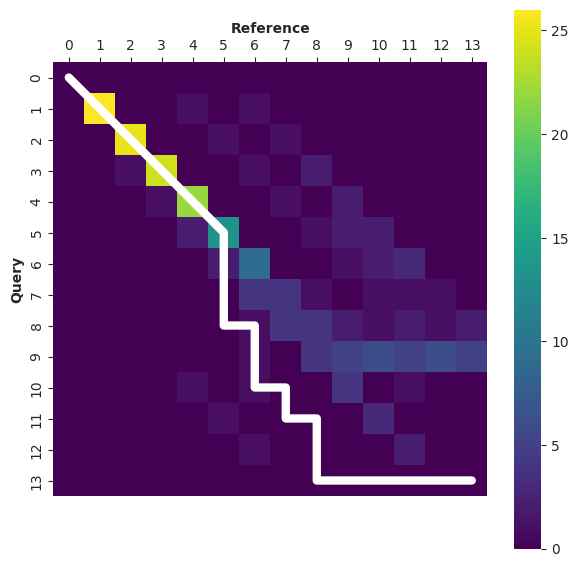

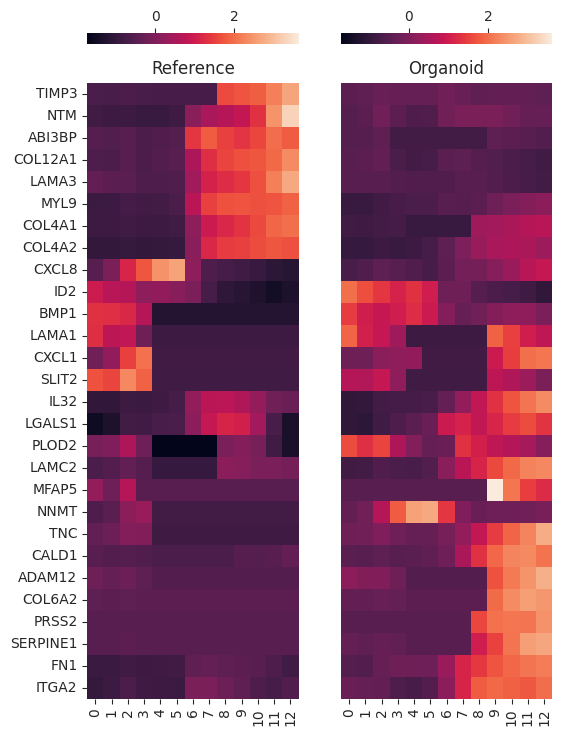

Average Alignment:  MMMMMIIIDIIDIDIIDDDDD


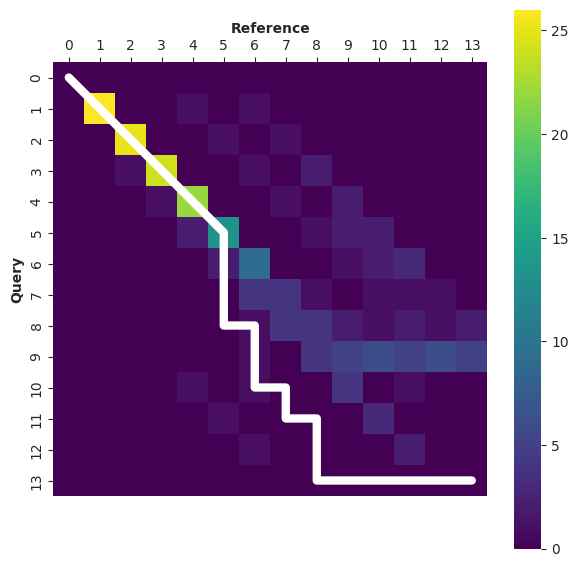

In [8]:
IGS = PathwayAnalyserV2.InterestingGeneSets(MSIGDB_PATH='../MSIGDB/msigdb7.5.1/')
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', common_hvg_genes, 'EMT')   
PathwayAnalyserV2.get_pathway_alignment_stat(aligner, IGS.SETS['EMT'], 'EMT', 
                                             cluster=True, FIGSIZE=(6,10))
aligner.get_aggregate_alignment_for_subset(IGS.SETS['EMT'])
#plt.savefig('MS_FIGS/HealthyIPF/EMT_average_alignment.png')

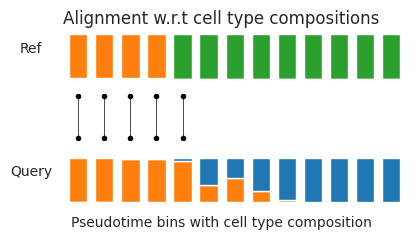

In [20]:
vs.visualize_gene_alignment('MMMMMIIIDIIDIDIIDDDDD', cmap=joint_cmap)
plt.savefig('MS_FIGS/HealthyIPF/EMT_average_alignment_illustration.png')

mean matched percentage:  39.48 %
mean matched percentage wrt ref:  54.63 %
mean matched percentage wrt query:  51.66 %
Average Alignment:  MMMMMIIIDIIDIIDIDDDDD
Z-normalised Interpolated mean trends


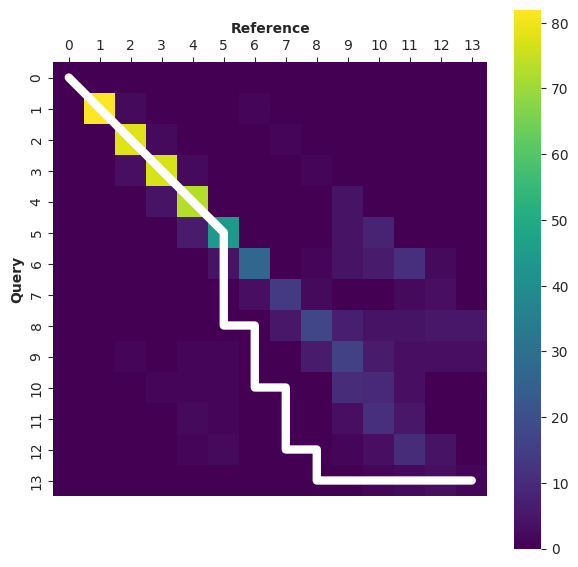

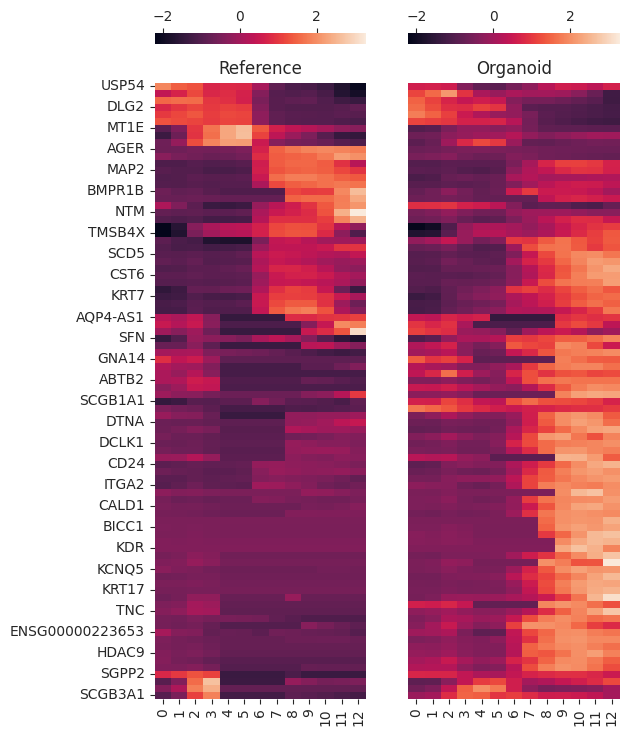

Average Alignment:  MMMMMIIIDIIDIIDIDDDDD


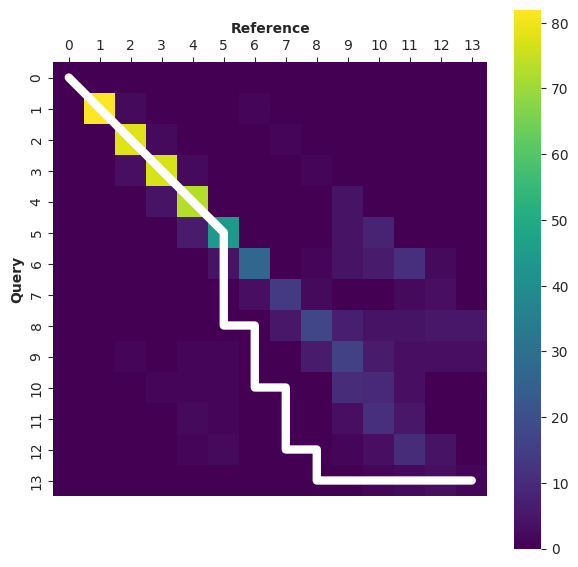

In [10]:
d = pd.read_csv('Genesets/Z_ABC_Markers_from original_paper_aba1983_data_s2.txt', sep='\t')
IGS.add_new_set( np.intersect1d(common_hvg_genes,  np.asarray(d[d.cellType=='Aberrant Basaloid'].gene) ), 'ABC_markers' , common_hvg_genes )

PathwayAnalyserV2.get_pathway_alignment_stat(aligner, IGS.SETS['ABC_markers'], 'ABC_markers', 
                                             cluster=True, FIGSIZE=(6,10))

aligner.get_aggregate_alignment_for_subset(IGS.SETS['ABC_markers'])
#plt.savefig('MS_FIGS/HealthyIPF/ABC_average_alignment.png')

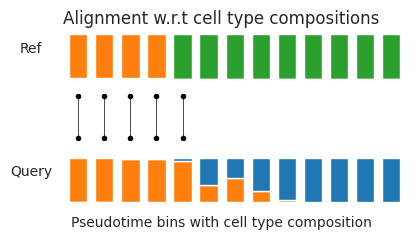

In [24]:
vs.visualize_gene_alignment('MMMMMIIIDIIDIIDIDDDDD', cmap=joint_cmap)
plt.savefig('MS_FIGS/HealthyIPF/ABC_average_alignment_illustration.png')

KRT17 DMMMIDIDIDIIIIIIIDDDDDD
MMP7 DMMMIDIDIDIIIIIIIDDDDDD
FN1 MMMMDDDDMMIIDIIIIIDD


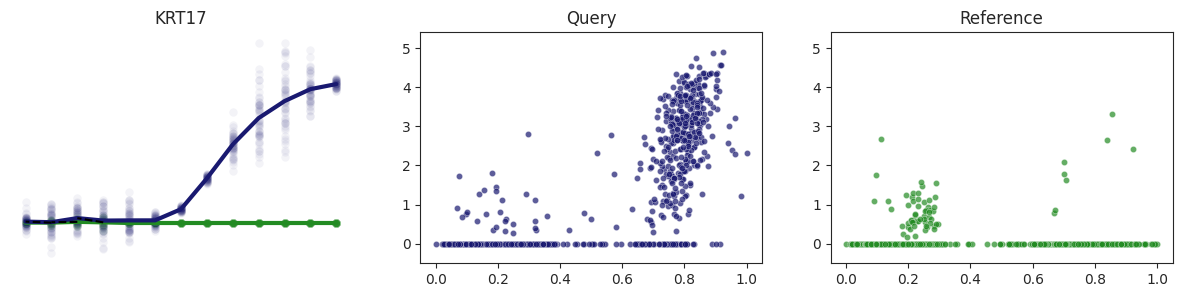

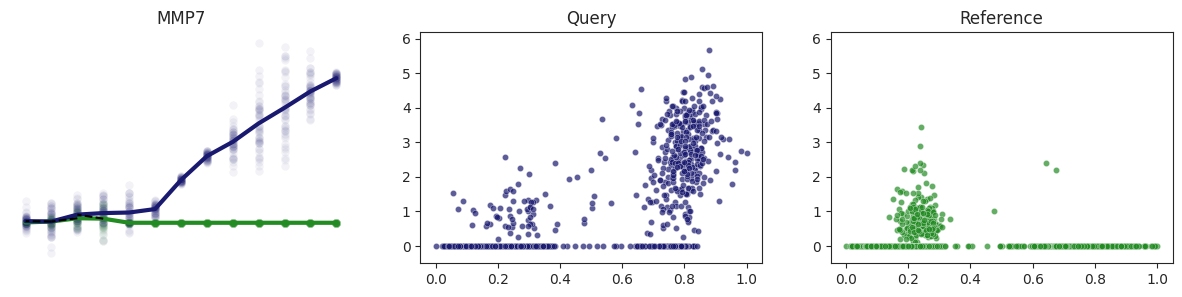

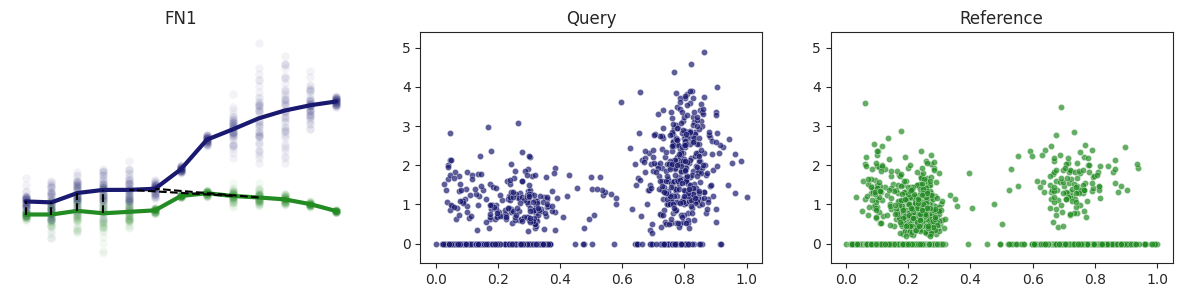

In [26]:
for g in ['KRT17','MMP7','FN1']:
    VisualUtils.plotTimeSeries(g, aligner, plot_cells=True)
    print(g, VisualUtils.color_al_str(aligner.results_map[g].alignment_str) )
    #plt.savefig('MS_FIGS/HealthyIPF/'+g+'.png', bbox_inches='tight',transparent=True)
   # plt.clf()

compute distance matrix
using levenshtein distance metric


 66%|██████▌   | 65/99 [00:11<00:05,  5.86it/s]


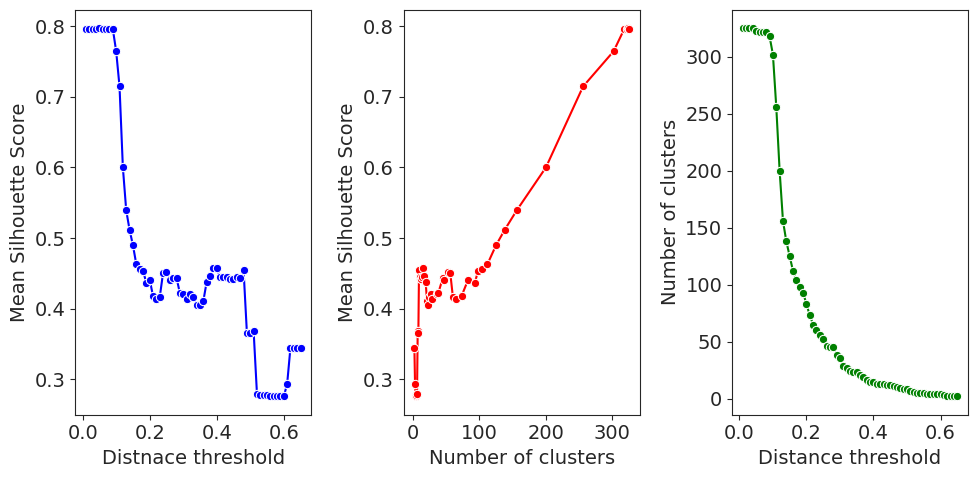

In [27]:
# Running experiment to determine the distance threshold with a good trade-off
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True) 
plt.savefig('MS_FIGS/HealthyIPF/Clustering_diagnostic_plots_levenshtein.png')

In [96]:
temp = []
for a in aligner.results:
    temp.append(a.alignment_str)
len(np.unique(temp))

325

In [98]:
df

Distance threshold  Mean Silhouette Score  Number of clusters
0                 0.01               0.871227               234.0
1                 0.02               0.871227               234.0
2                 0.03               0.871227               234.0
3                 0.04               0.819263               217.0
4                 0.05               0.808145               214.0
5                 0.06               0.781925               206.0
6                 0.07               0.757463               205.0
7                 0.08               0.617129               107.0
8                 0.09               0.550031                99.0
9                 0.10               0.546186                93.0
10                0.11               0.538839                85.0
11                0.12               0.514724                76.0
12                0.13               0.509571                67.0
13                0.14               0.524611                59.0
14                0.15               0.504696                53.0
15                0.16               0.478321                47.0
16                0.17               0.462281                42.0
17                0.18               0.412594                39.0
18                0.19               0.410172                37.0
19                0.20               0.280651                33.0
20                0.21               0.301483                29.0
21                0.22               0.313355                26.0
22                0.23               0.316595                24.0
23                0.24               0.289846                22.0
24                0.25               0.299464                20.0
25                0.26               0.310188                19.0
26                0.27               0.350416                16.0
27                0.28               0.220626                13.0
28                0.29               0.287756                11.0
29                0.30               0.280241                10.0
30                0.31               0.321132                 8.0
31                0.32               0.321132                 8.0
32                0.33               0.321132                 8.0
33                0.34               0.364859                 6.0
34                0.35               0.369467                 5.0
35                0.36               0.369467                 5.0
36                0.37               0.369467                 5.0
37                0.38               0.369467                 5.0
38                0.39               0.369467                 5.0
39                0.40               0.369467                 5.0
40                0.41               0.369467                 5.0
41                0.42               0.472048                 3.0
42                0.43               0.472048                 3.0
43                0.44               0.472048                 3.0
44                0.45               0.472048                 3.0
45                0.46               0.472048                 3.0
46                0.47               0.498253                 2.0
47                0.48               0.498253                 2.0
48                0.49               0.498253                 2.0

compute distance matrix
using hamming distance metric


 49%|████▉     | 49/99 [00:01<00:01, 30.26it/s]


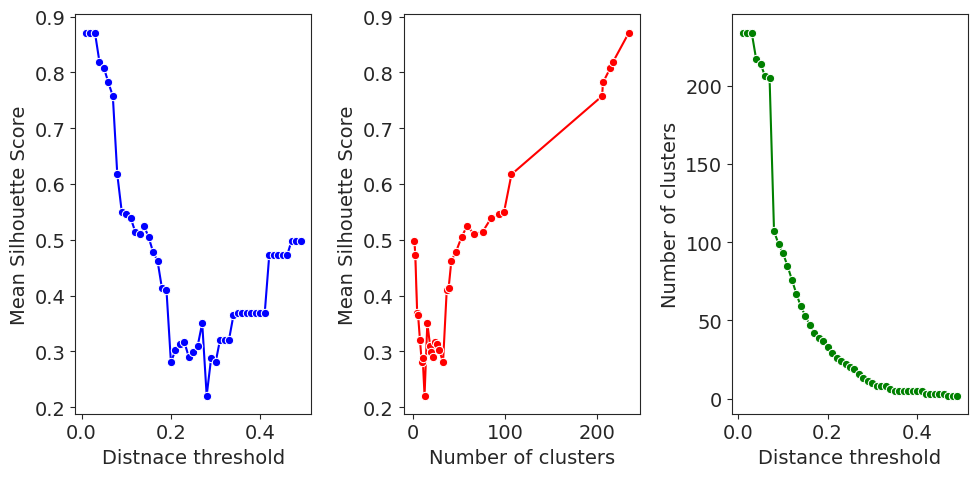

In [97]:
# Running experiment to determine the distance threshold with a good trade-off
df = ClusterUtils.run_clustering(aligner, metric='hamming', experiment_mode=True) 
plt.savefig('MS_FIGS/HealthyIPF/Clustering_diagnostic_plots_hamming.png')

In [31]:
df.sort_values('Number of clusters', ascending=True)[0:45]

Distance threshold  Mean Silhouette Score  Number of clusters
64                0.65               0.344795                 2.0
61                0.62               0.344795                 2.0
63                0.64               0.344795                 2.0
62                0.63               0.344795                 2.0
60                0.61               0.292828                 3.0
59                0.60               0.275602                 4.0
58                0.59               0.275602                 4.0
57                0.58               0.275602                 4.0
56                0.57               0.275602                 4.0
55                0.56               0.275602                 4.0
54                0.55               0.276872                 5.0
53                0.54               0.276872                 5.0
52                0.53               0.276872                 5.0
51                0.52               0.279531                 6.0
50                0.51               0.368724                 7.0
48                0.49               0.365667                 8.0
49                0.50               0.365667                 8.0
47                0.48               0.455083                 9.0
46                0.47               0.442853                10.0
45                0.46               0.444880                11.0
44                0.45               0.441906                12.0
43                0.44               0.441906                12.0
42                0.43               0.444201                13.0
41                0.42               0.444201                13.0
40                0.41               0.444201                13.0
39                0.40               0.458208                15.0
38                0.39               0.458208                15.0
37                0.38               0.445829                16.0
36                0.37               0.437779                19.0
35                0.36               0.410612                21.0
34                0.35               0.404567                23.0
33                0.34               0.404567                23.0
32                0.33               0.416108                24.0
31                0.32               0.420030                27.0
30                0.31               0.414242                29.0
29                0.30               0.420205                36.0
28                0.29               0.421955                38.0
27                0.28               0.443937                45.0
26                0.27               0.443937                45.0
25                0.26               0.441117                46.0
24                0.25               0.451977                52.0
23                0.24               0.450856                56.0
22                0.23               0.416194                60.0
21                0.22               0.413977                65.0
20                0.21               0.417689                73.0

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.48
silhouette_score:  0.4550833638079494


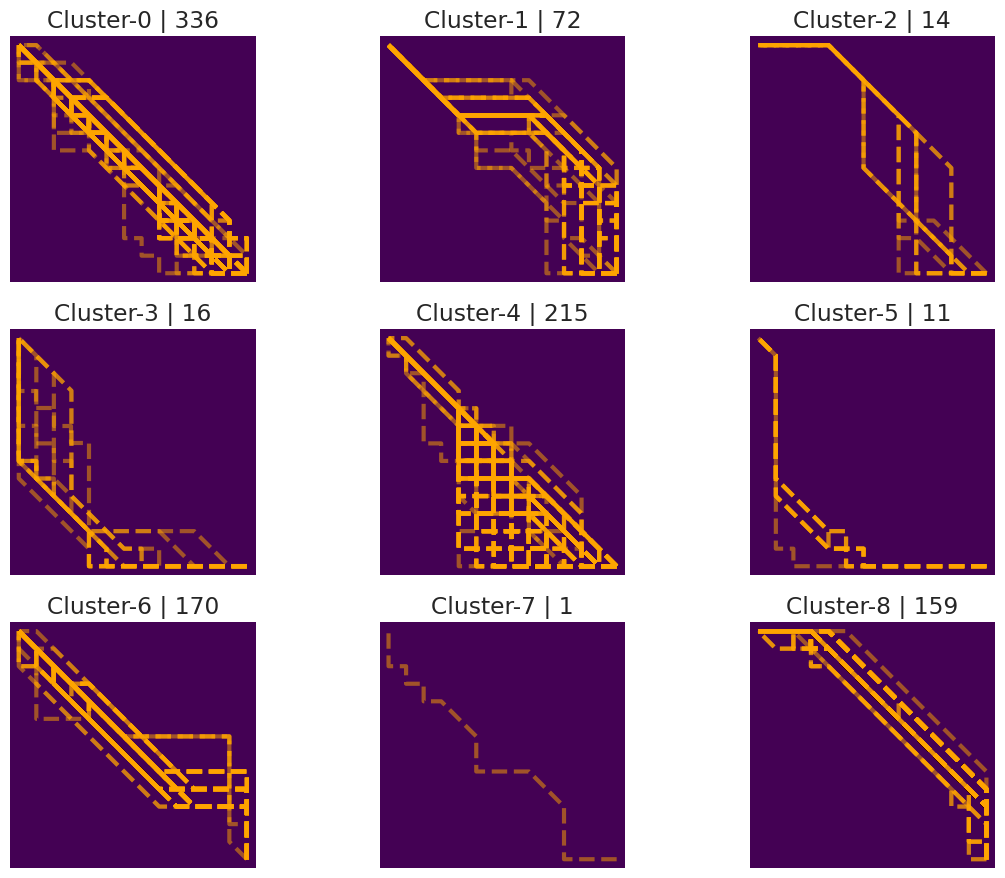

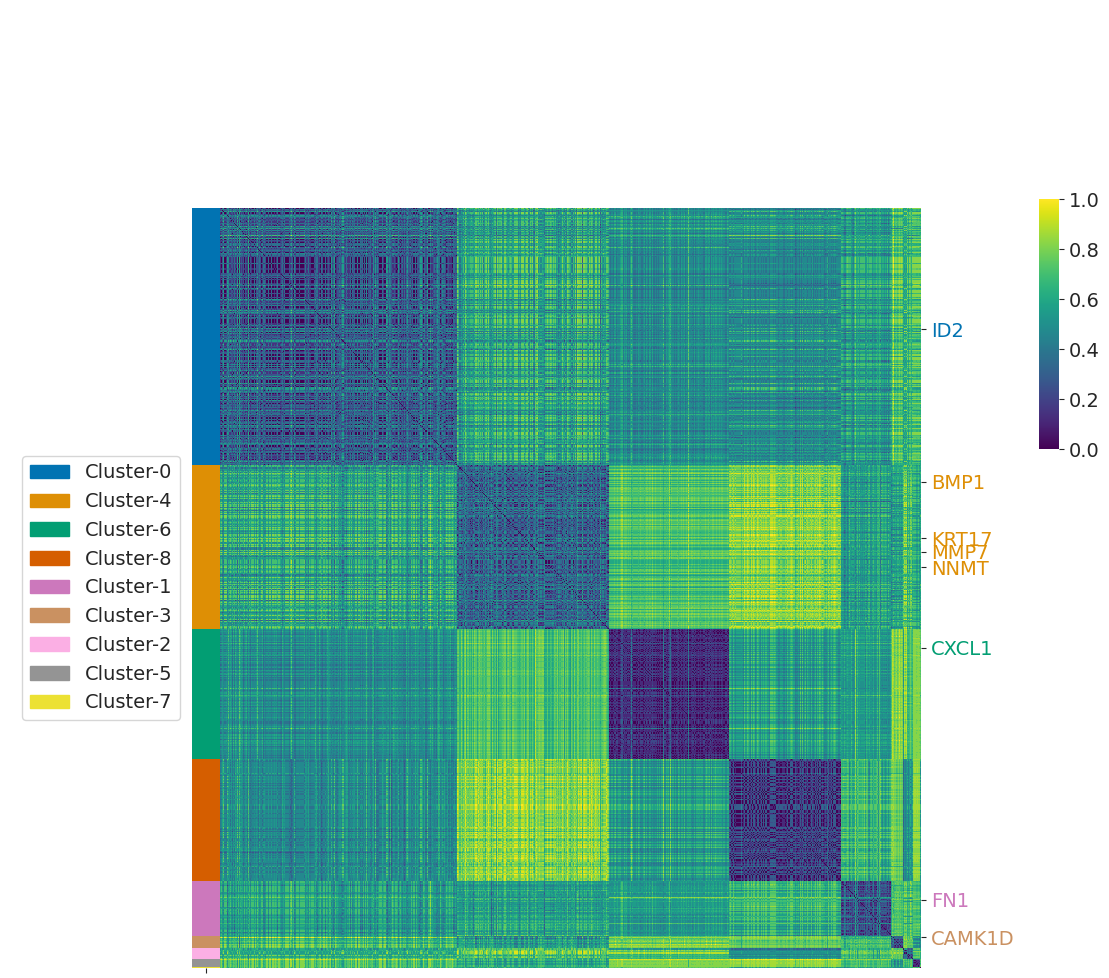

In [60]:
# Obtain clustering for the selected distance threshold
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.48) 
ClusterUtils.visualise_clusters(aligner,n_cols = 3, figsize= (5,6))
plt.savefig('MS_FIGS/HealthyIPF/clusters.png' ,bbox_inches='tight')
VisualUtils.plot_distmap_with_clusters(aligner,cmap='gist_ncar',vmin = 0, vmax = 0.8, 
                                       genes2highlight=['CAMK1D','KRT17','MMP7','FN1','CXCL1','NNMT', 'BMP1', 'ID2'])
plt.savefig('MS_FIGS/HealthyIPF/clustermap_high_res.png', bbox_inches='tight')

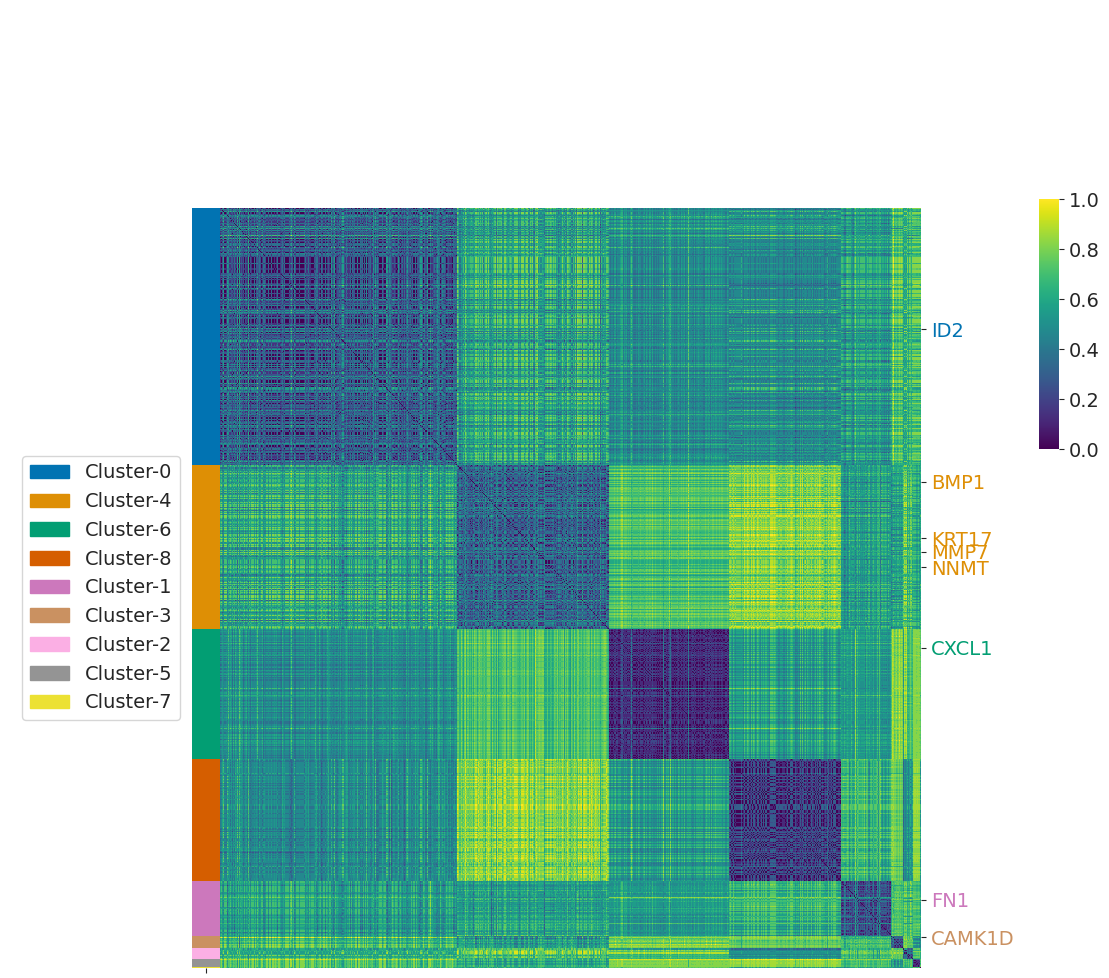

In [48]:
VisualUtils.plot_distmap_with_clusters(aligner,cmap='gist_ncar',vmin = 0, vmax = 0.8, 
                                       genes2highlight=['CAMK1D','KRT17','MMP7','FN1','CXCL1','NNMT', 'BMP1', 'ID2'])

In [49]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 MMMMMMMMVMMMIDD 336
cluster:  1 MMMMDDDDMMMIDIIIIID 72
cluster:  2 IIDDDDMMMMMVVVMMIDD 14
cluster:  3 IIIDIIIIIMMMMIDDDDDDDD 16
cluster:  4 MMMMIIIIDIIDIDIIDDDDDD 215
cluster:  5 MIVVVVVVVMMMIDDDDDDDDD 11
cluster:  6 MMMMMMMMMWWWWIIII 170
cluster:  7 IIIDIDDMMIIDDDMMIIIDDD 1
cluster:  8 IDDDDMMMMMMMMMIII 159


In [52]:
#for g in aligner.gene_clusters[3]:
#    VisualUtils.plotTimeSeries(g,aligner)

In [51]:
#for i in range(0,9):
#    print('CAMK1D' in aligner.gene_clusters[i])

#VisualUtils.plotTimeSeries('CST6',aligner)
#aligner.gene_clusters[7]

IIIDIDIDIDIIIIIIIDDDDDDDDD
CAMK1D IIIDIDIDIDIIIIIIIDDDDDDDDD


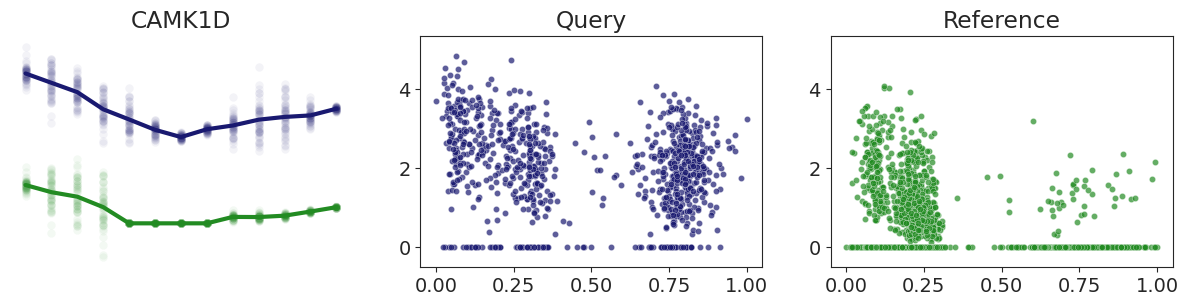

In [39]:
for g in ['CAMK1D']:
    VisualUtils.plotTimeSeries(g, aligner, plot_cells=True)
    print(aligner.results_map[g].alignment_str)
    print(g, VisualUtils.color_al_str(aligner.results_map[g].alignment_str) )
    plt.savefig('MS_FIGS/HealthyIPF/'+g+'.png', bbox_inches='tight',transparent=True)

CXCL1 MIMMMMMMMWWWWWIIII
CXCL8 MMDDDDDMMMMIIDIIIIID
SLIT2 MMMMMMMMMWWWWIIII


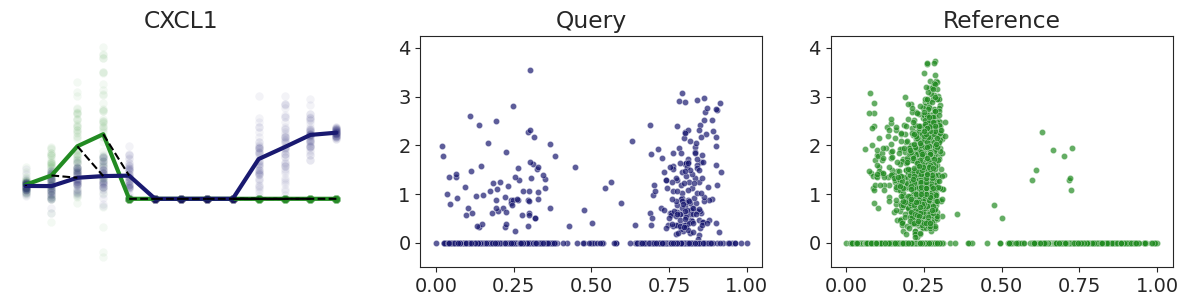

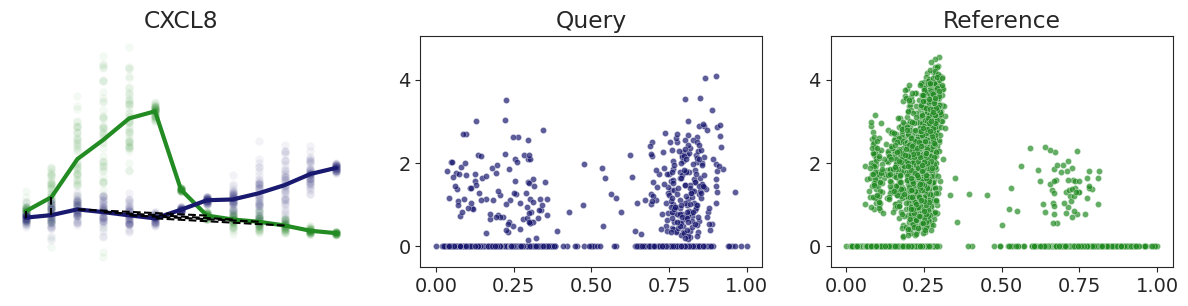

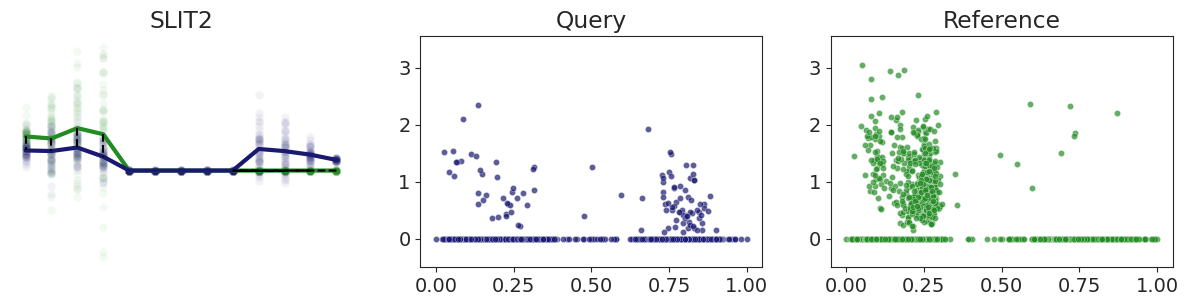

In [62]:
for g in ['CXCL1', 'CXCL8', 'SLIT2']:
    VisualUtils.plotTimeSeries(g, aligner, plot_cells=True)
    print(g, VisualUtils.color_al_str(aligner.results_map[g].alignment_str) )
    #plt.savefig('plots/Fig4/volcano_like_plot_related/'+g+'.png', bbox_inches='tight',transparent=True)
    #plt.clf()

MMMMDDDDMMMIIDIIIID
Optimal alignment cost: 39.273 nits
Alignment similarity percentage: 36.84 %


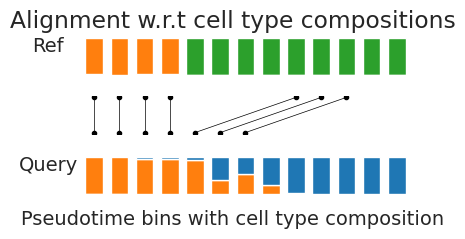

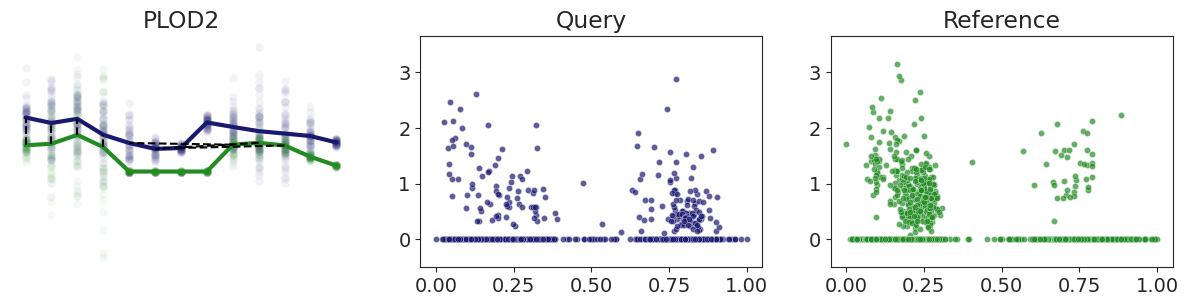

In [67]:
VisualUtils.show_gene_alignment('PLOD2', aligner, vs, joint_cmap)

MMDDDDDMMMMIIDIIIIID
Optimal alignment cost: 45.56 nits
Alignment similarity percentage: 30.0 %
MMMMIIIDIDIDIDIIIDDDDD
Optimal alignment cost: 48.649 nits
Alignment similarity percentage: 18.18 %
MIMMMMMMMWWWWWIIII
Optimal alignment cost: 29.392 nits
Alignment similarity percentage: 72.22 %


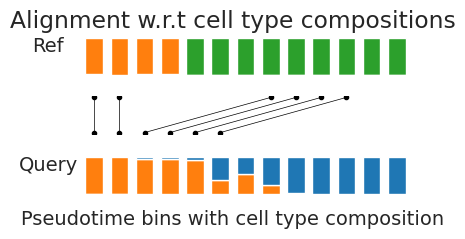

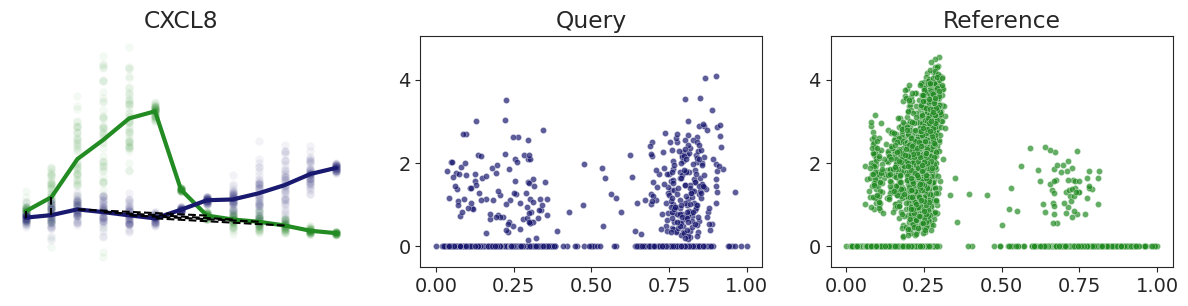

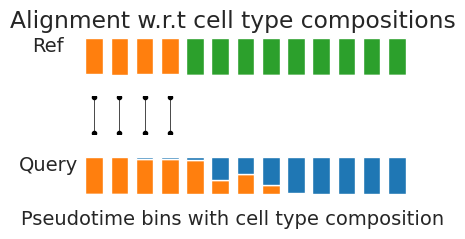

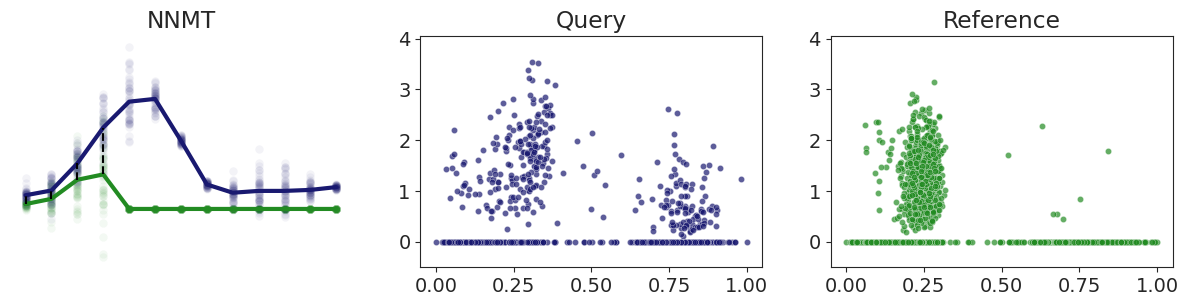

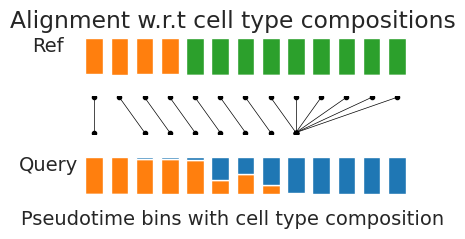

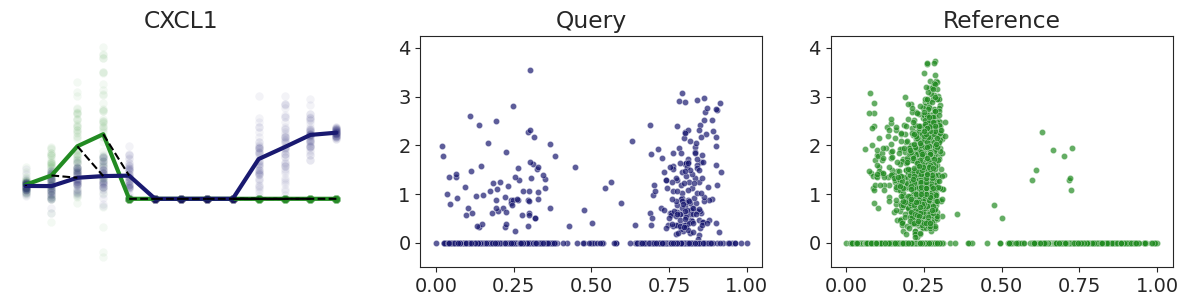

In [66]:
VisualUtils.show_gene_alignment('CXCL8', aligner, vs, joint_cmap)
VisualUtils.show_gene_alignment('NNMT', aligner, vs, joint_cmap)
VisualUtils.show_gene_alignment('CXCL1', aligner, vs, joint_cmap)
#plt.savefig('plots/Illustrations/gene_JUNB_refato.png')

NNMT MMMMIIIDIDIDIDIIIDDDDD
BMP1 MMMMIIIIIIDIDIDIDDDDDD
ID2 MMMMMIMMMMMMIDD
PLOD2 MMMMDDDDMMMIIDIIIID


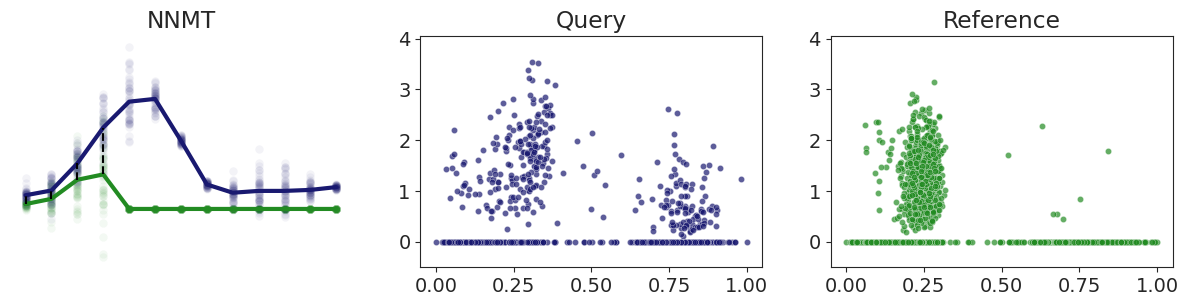

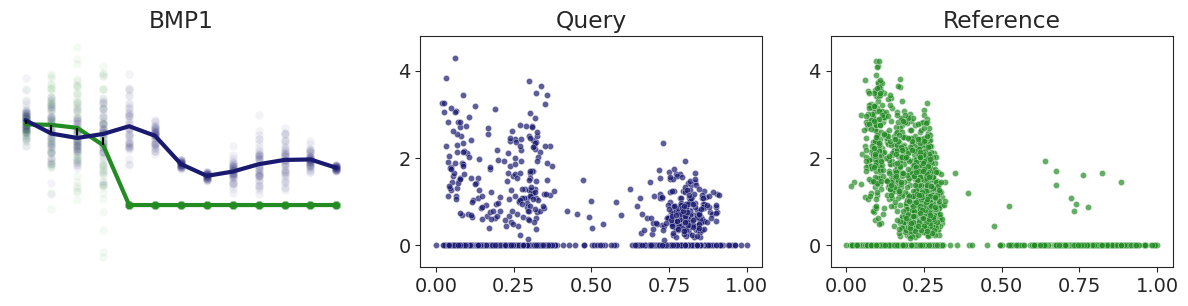

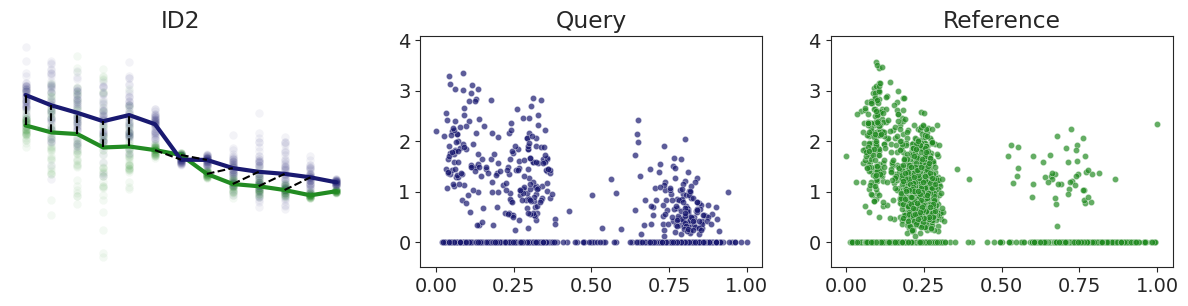

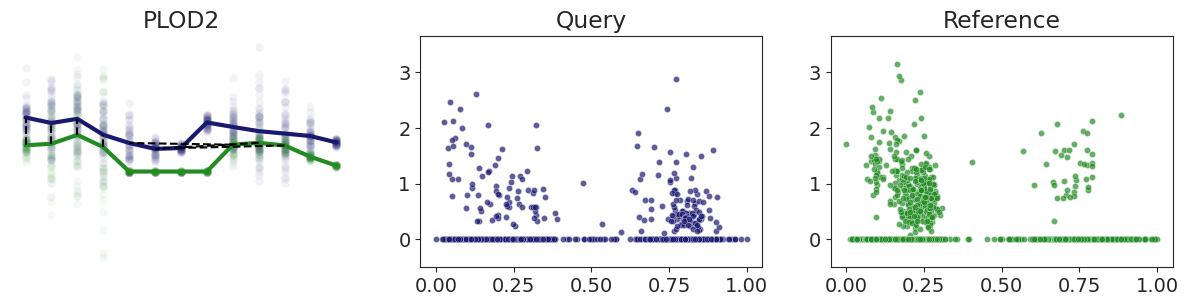

In [63]:
for g in ['NNMT', 'BMP1', 'ID2', 'PLOD2']:
    VisualUtils.plotTimeSeries(g, aligner, plot_cells=True)
    print(g, VisualUtils.color_al_str(aligner.results_map[g].alignment_str) )
    #plt.savefig('plots/Fig4/volcano_like_plot_related/'+g+'.png', bbox_inches='tight',transparent=True)
    #plt.clf()

mean matched percentage:  39.48 %
mean matched percentage wrt ref:  54.63 %
mean matched percentage wrt query:  51.66 %
Average Alignment:  MMMMMIIIDIIDIIDIDDDDD
Z-normalised Interpolated mean trends


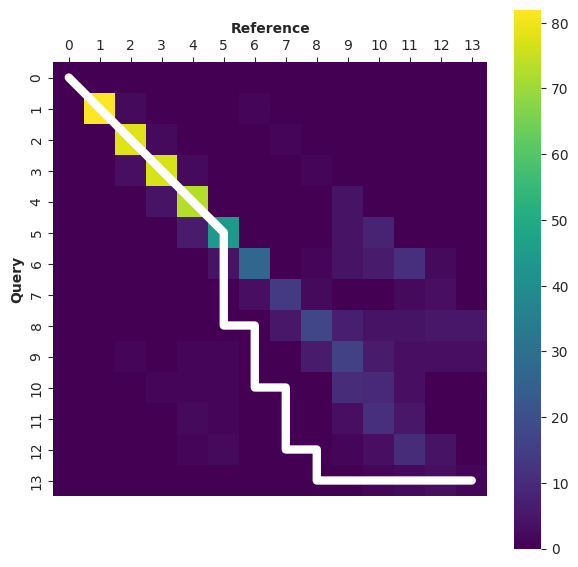

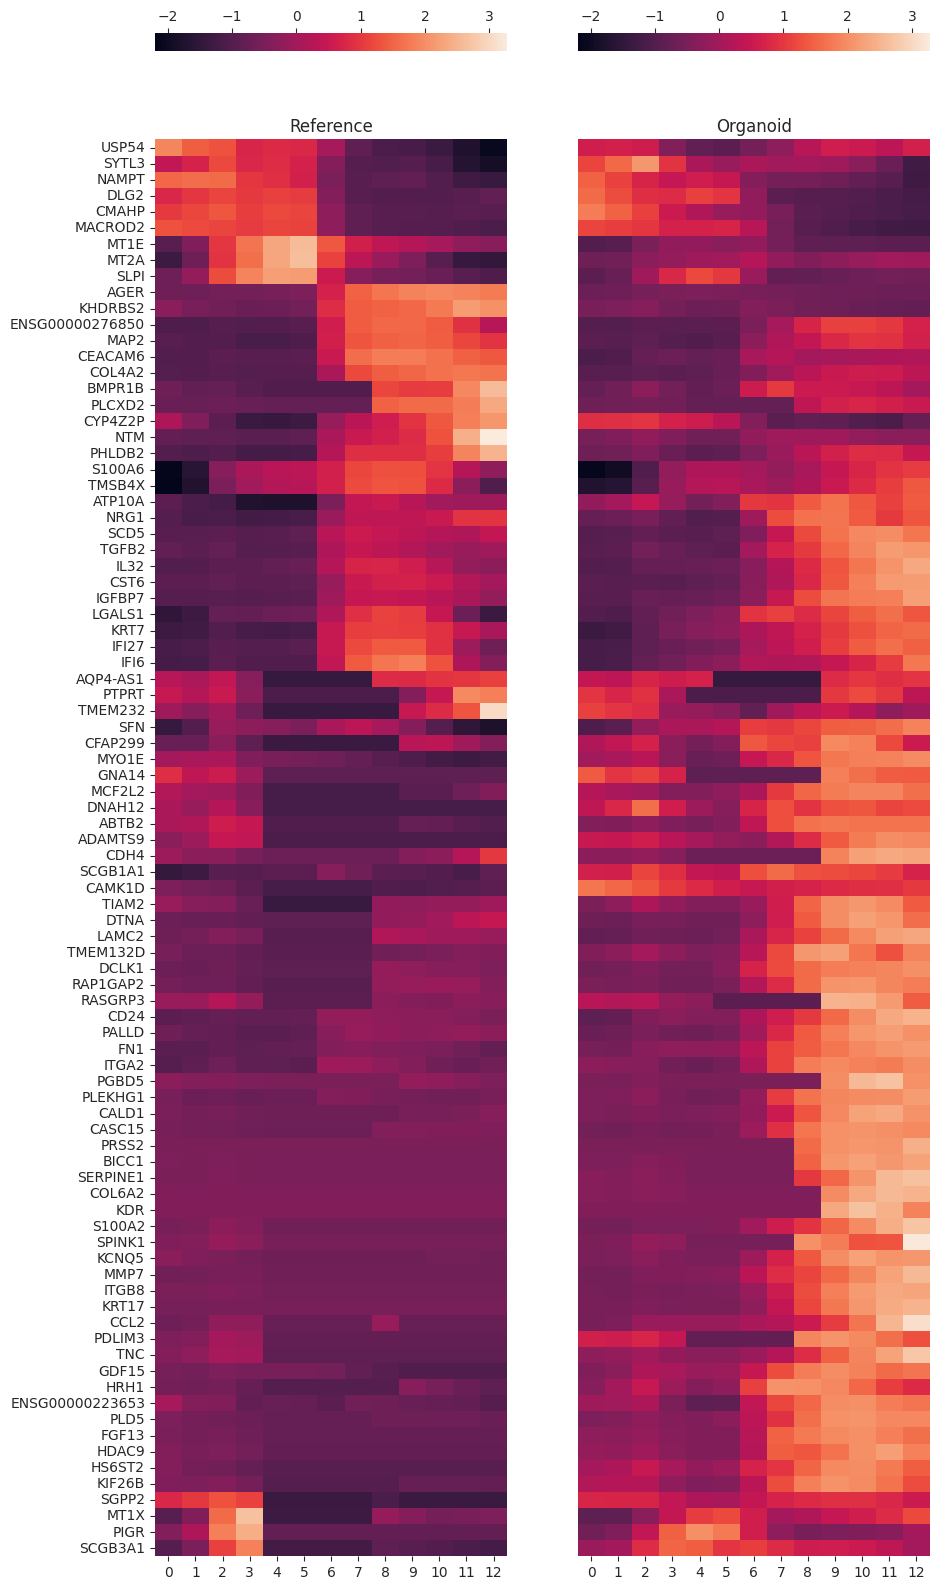

In [15]:
PathwayAnalyserV2.get_pathway_alignment_stat(aligner, IGS.SETS['ABC_markers'], 'ABC_markers', 
                                             cluster=True, FIGSIZE=(10,23))
#len(IGS.SETS['ABC_markers']) <-- 88 genes


# Supplementary

compute distance matrix
using hamming distance metric


 64%|██████▎   | 63/99 [00:02<00:01, 26.04it/s]


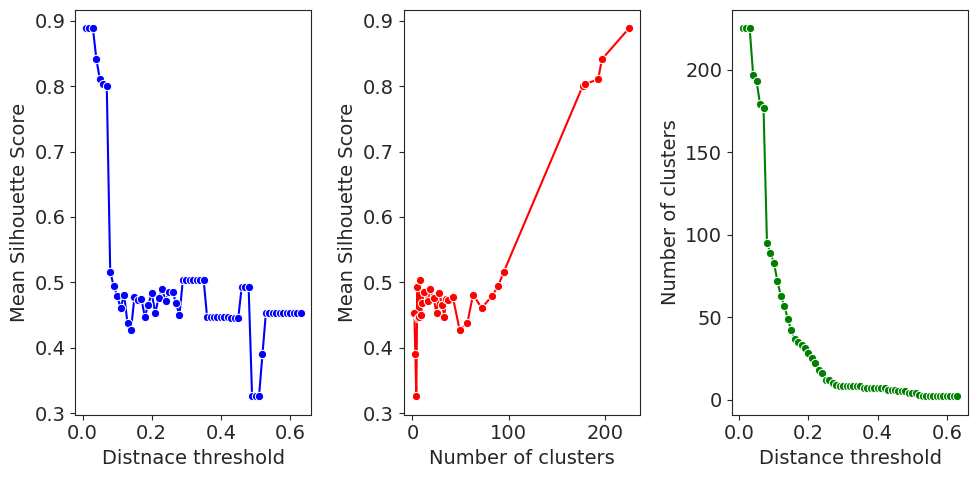

In [39]:
df = ClusterUtils.run_clustering(aligner, metric='hamming', experiment_mode=True)
df
plt.savefig('plots/Fig5/Clustering_Silhouette_plots1_hamming.png')

In [40]:
df

Distance threshold  Mean Silhouette Score  Number of clusters
0                 0.01               0.888330               225.0
1                 0.02               0.888330               225.0
2                 0.03               0.888330               225.0
3                 0.04               0.841204               197.0
4                 0.05               0.810554               193.0
..                 ...                    ...                 ...
58                0.59               0.453819                 2.0
59                0.60               0.453819                 2.0
60                0.61               0.453819                 2.0
61                0.62               0.453819                 2.0
62                0.63               0.453819                 2.0

[63 rows x 3 columns]

In [15]:
temp = []
for a in aligner.results:
    temp.append(a.alignment_str)
    
len(np.unique(temp)) 

325

# Writing results files

In [17]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.48) 

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.48
silhouette_score:  0.4550833638079494


In [18]:
df = []
for g in aligner.gene_list:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0], al_obj.cluster_id ] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %','Cluster_id']
df

Gene 5-state alignment string  Alignment similarity %  Cluster_id
0       AASS   MMMMIIIIIDIDIDIIDDDDDD                   18.18           4
1       AATK     MMMMDDDDMMIDIDIIIIID                   30.00           1
2      ABCA1     MMMMMMIIIIDIDIDIDDDD                   30.00           4
3      ABCA6        DDDDMMMMMMMMMVVVV                   76.47           8
4     ABCC13         MDDDMMMMMMMMMVVV                   81.25           8
..       ...                      ...                     ...         ...
989   ZNF773        DDDIDMMMMMMMMMIII                   52.94           8
990    ZNF79        MMMMMMMMMWWWWIIII                   76.47           6
991      ZP3         MMMMMMIIDMMMMDID                   62.50           0
992  ZSCAN31         MMMMIDMMMMMMIDID                   62.50           0
993   ZSWIM4     MMMMMMIIIIDIDIDIDDDD                   30.00           4

[994 rows x 4 columns]

In [22]:
df.to_csv('results/G2G_HealthyIPF_alignments.csv')

In [ ]:
import PathwayAnalyserV2

# Cluster specific overepresentation analysis ---> Clusters do not necessarily output similar gene programs -- If one pathway is overrepresented in several clusters, that means 
# that particular pathway has several gene subsets which match/mismatch differently along pseudotime. 
# Such clusters reveal pathways with such varying alignments
# They could be DE or non DE; Also a cluster might not have any significant overepresentation result as well
from tqdm import tqdm
import gseapy as gp
from gseapy import barplot, dotplot
import anndata
import time 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
import pickle
from tqdm import tqdm
from tabulate import tabulate
def run_overrepresentation_analysis(gene_set, TARGET_GENESETS=['MSigDB_Hallmark_2020','KEGG_2021_Human']):
    enr = gp.enrichr(gene_list=gene_set,
                     gene_sets=TARGET_GENESETS,
                     organism='human',
                     outdir=None,
                       )
    df = enr.results[enr.results['Adjusted P-value']<0.05]
    if(df.shape[0]==0):
        return df
    df = df.sort_values('Adjusted P-value')
    df['-log10 Adjusted P-value'] = [-np.log10(q) for q in df['Adjusted P-value']]
    max_q = max(df['-log10 Adjusted P-value'][df['-log10 Adjusted P-value']!=np.inf])
    #df.columns = ['Gene_set']+list(df.columns[1:len(df.columns)])
    qvals = []
    for q in df['-log10 Adjusted P-value']:
        if(q==np.inf):
            q = -np.log10(0.00000000001) # NOTE: For -log10(p=0.0) we replace p with a very small p-val to avoid inf
        qvals.append(q)
    df['-log10 FDR q-val'] = qvals 
    df = df.sort_values('Adjusted P-value',ascending=True)
    return df
def run_cluster_overrepresentation_analysis(aligner):

    overrep_cluster_results = {}
    cluster_overrepresentation_results = [] 

    for cluster_id in tqdm(range(len(aligner.gene_clusters))):
        df = run_overrepresentation_analysis(aligner.gene_clusters[cluster_id])
        if(df.shape[0]==0):
            continue
        n_genes = len(aligner.gene_clusters[cluster_id])
        pathways = list(df.Term) 
        pathway_specific_genes = list(df.Genes) 
        sources = [str(s).split('_')[0] for s in list(df.Gene_set)] 

        if(n_genes<15):
            genes = aligner.gene_clusters[cluster_id]
        else:
            genes = aligner.gene_clusters[cluster_id][1:7] + [' ... '] +  aligner.gene_clusters[cluster_id][n_genes-7:n_genes]

        cluster_overrepresentation_results.append([cluster_id,n_genes,genes,pathways, pathway_specific_genes, sources]) 
        overrep_cluster_results[cluster_id] = df 

    results= pd.DataFrame(cluster_overrepresentation_results)
    #print(tabulate(results,  headers=['cluster_id','n_genes', 'Cluster genes', 'Pathways','Pathway genes','Source'],tablefmt="grid",maxcolwidths=[3, 3, 3,30,40,40,10])) 
    return overrep_cluster_results, results
    
#PathwayAnalyserV2.run_cluster_overrepresentation_analysis(aligner)
overrep_cluster_results, results = run_cluster_overrepresentation_analysis(aligner)
cid = 0
for cluster in aligner.gene_clusters:
    print(cid)
    for g in cluster:
        aligner.results_map[g].cluster_id = cid
    cid+=1
    

In [79]:
df = []
for g in aligner.gene_list:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0], al_obj.cluster_id ] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %','Cluster_id']
df

Gene 5-state alignment string  Alignment similarity %  Cluster_id
0       AASS  IMMMMMMMIIIIIIIDDDDDDDD                   30.43          18
1       AATK      MMMMMMMDMMMMIIIIDDD                   57.89           5
2      ABCA1  MMMMMMMIIIIIIIIDDDDDDDD                   30.43          18
3      ABCA6        MMMMMMMIIDDMMMMMM                   76.47           8
4     ABCC13         MMMMMMMMMMMMMMID                   87.50           5
..       ...                      ...                     ...         ...
989   ZNF773       IMMMMMMMIIDDMMMMMD                   66.67           8
990    ZNF79  MMMMMMMIIIIIIIIDDDDDDDD                   30.43          18
991      ZP3  MMMMMMMDWWWWWIIIIIIIIDD                   52.17           0
992  ZSCAN31        MMMMMMMMMMMMMIIDD                   76.47           5
993   ZSWIM4  MMMMMMMIIIIIIIIDDDDDDDD                   30.43          18

[994 rows x 4 columns]

In [82]:
np.unique(df['Cluster_id'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [83]:
df.to_csv('ms_sup_tables/HealthyIPF_all_gene_alignments.csv')

In [84]:
aligner.gene_clusters[12]

['CAMK1D', 'ENSG00000236039', 'NTM', 'RCAN2', 'SCGB1A1', 'SLC7A2']

In [87]:
df = df.set_index('Gene')
df.loc[aligner.gene_clusters[12]]

5-state alignment string  Alignment similarity %  \
Gene                                                                      
CAMK1D           IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
ENSG00000236039  IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
NTM              IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
RCAN2            IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
SCGB1A1          IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
SLC7A2           IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   

                 Cluster_id  
Gene                         
CAMK1D                   12  
ENSG00000236039          12  
NTM                      12  
RCAN2                    12  
SCGB1A1                  12  
SLC7A2                   12

In [90]:
# Overrepresentation analysis of the top DE TFs along pseudotime based on alignment percentage < 40% 
import PathwayAnalyserV2
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.25)
df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes)

df

55  # of DE genes to check


Gene_set                                               Term  \
0   MSigDB_Hallmark_2020                  Epithelial Mesenchymal Transition   
1   MSigDB_Hallmark_2020                                        Coagulation   
2   MSigDB_Hallmark_2020                              Inflammatory Response   
21       KEGG_2021_Human                            IL-17 signaling pathway   
22       KEGG_2021_Human                                         Amoebiasis   
3   MSigDB_Hallmark_2020                      TNF-alpha Signaling via NF-kB   
4   MSigDB_Hallmark_2020                                  KRAS Signaling Up   
23       KEGG_2021_Human                           ECM-receptor interaction   
24       KEGG_2021_Human                               Rheumatoid arthritis   
25       KEGG_2021_Human                                     Focal adhesion   
26       KEGG_2021_Human                            Proteoglycans in cancer   
27       KEGG_2021_Human  AGE-RAGE signaling pathway in diabetic complic...   
28       KEGG_2021_Human  Viral protein interaction with cytokine and cy...   
29       KEGG_2021_Human                       NF-kappa B signaling pathway   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   10/200  1.578265e-10      3.314357e-09            0                     0   
1    5/138  3.834432e-05      4.026154e-04            0                     0   
2    5/200  2.205026e-04      1.543518e-03            0                     0   
21    4/94  1.298924e-04      9.082512e-03            0                     0   
22   4/102  1.780885e-04      9.082512e-03            0                     0   
3    4/200  2.222170e-03      9.333112e-03            0                     0   
4    4/200  2.222170e-03      9.333112e-03            0                     0   
23    3/88  1.830470e-03      3.337678e-02            0                     0   
24    3/93  2.143730e-03      3.337678e-02            0                     0   
25   4/201  2.262708e-03      3.337678e-02            0                     0   
26   4/205  2.429976e-03      3.337678e-02            0                     0   
27   3/100  2.635341e-03      3.337678e-02            0                     0   
28   3/100  2.635341e-03      3.337678e-02            0                     0   
29   3/104  2.945010e-03      3.337678e-02            0                     0   

    Odds Ratio  Combined Score  \
0    23.105263      521.474806   
1    14.896241      151.478441   
2    10.128205       85.275446   
21   17.302832      154.839656   
22   15.883954      137.129826   
3     7.902761       48.280112   
4     7.902761       48.280112   
23   13.479638       84.964622   
24   12.727564       78.213526   
25    7.862247       47.890466   
26    7.704224       46.378455   
27   11.804917       70.106361   
28   11.804917       70.106361   
29   11.335110       66.056977   

                                                Genes  \
0   CXCL8;NNMT;ITGA2;COL6A2;NTM;SERPINE1;FN1;TIMP3...   
1                       MMP7;ITGA2;SERPINE1;FN1;TIMP3   
2                   CXCL8;IL1R1;CCL20;SERPINE1;SLC7A2   
21                           CXCL8;CCL20;CXCL1;DEFB4A   
22                              CXCL8;IL1R1;FN1;CXCL1   
3                          CCL20;SERPINE1;CXCL1;PLPP3   
4                           CCL20;ITGA2;HKDC1;ANGPTL4   
23                                   ITGA2;COL6A2;FN1   
24                                  CXCL8;CCL20;CXCL1   
25                               ITGA2;COL6A2;FN1;KDR   
26                                ITGA2;FN1;KDR;TIMP3   
27                                 CXCL8;SERPINE1;FN1   
28                                  CXCL8;CCL20;CXCL1   
29                                  CXCL8;IL1R1;CXCL1   

    -log10 Adjusted P-value  -log10 FDR q-val  
0                  8.479601          8.479601  
1                  3.395110          3.395110  
2                  2.811488          2.811488  
21                 2.041794          2.041794  
22     

In [92]:
df.to_csv('ms_sup_tables/HealthyIPF_all_overrep_results_top_k_DE_threshold_0.25sim_55genes.csv')

In [93]:
for cid in range(len(aligner.gene_clusters)):
    if(cid in overrep_cluster_results.keys()):
        overrep_cluster_results[cid].to_csv('ms_sup_tables/HealthyIPF_all_cluster_pathways_overrep_results/HealthyIPF_all_cluster_'+str(cid)+'_pathways.csv')